In [1]:
import os

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, MaxPool1D, GlobalAvgPool1D

In [2]:
os.getcwd()

'/home/anthony/summer-bursary-2018/bacteria'

In [3]:
os.listdir('data')

['Classific.py',
 'graphs.pdf',
 'growth_stages.csv',
 '16ms_32ms_growth_phase_spectra.csv',
 'bacteria_32ms.csv',
 'PC6allwavelengths.png',
 'bacteria_16ms.csv',
 'wavelengths.csv',
 '16_ms_lag_codes.csv',
 'bacteria.csv']

In [4]:
df_16ms = pd.read_csv('data/bacteria_16ms.csv', header=[0, 1, 2, 3], index_col=0)
df_16ms.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1043 entries, 0 to 1042
Columns: 135 entries, (lag, positive, bc, 01) to (stat, negative, se, 07)
dtypes: float64(135)
memory usage: 1.1 MB


In [5]:
df_16ms.describe()

growth_phase          lag                                                      \
gramness         positive                                                       
species                bc                                                       
replicate              01           02           03           04           05   
count         1043.000000  1043.000000  1043.000000  1043.000000  1043.000000   
mean           340.917966   218.282554   410.265450   402.411758   147.930946   
std            517.453981   328.263253   632.792734   584.358827   213.381498   
min             -3.510400    -2.800760    -2.581292    -2.554170    -2.985820   
25%              3.738191     2.116139     3.614560     4.258268     3.017208   
50%             40.780240    27.023980    48.616896    58.972290    24.396270   
75%            496.754350   319.173550   571.801010   629.260350   223.730650   
max           1649.755000  1044.867000  2050.509445  1755.384000   670.982500   

growth_phase                                                                   \
gramness                                                                        
species                                                                         
replicate              06           07           08           09           10   
count         1043.000000  1043.000000  1043.000000  1043.000000  1043.000000   
mean           304.443366   690.243351   615.625463   508.217097   267.395909   
std            457.365956  1076.320701  1006.404767   829.675942   411.266389   
min             -3.429370    -2.280780    -4.327390    -3.340390   -24.324100   
25%              3.429760     4.382186     3.291279     3.093110    -1.435505   
50%             37.316280    78.138510    46.407810    41.594080    26.498390   
75%            446.739200   940.880800   775.154550   630.964700   401.714900   
max           1426.308000  3542.053000  3369.752000  2848.575000  1316.226000   

growth_phase     ...              stat                                         \
gramness         ...          positive                               negative   
species          ...                sa                                     se   
replicate        ...                06           07           08           01   
count            ...       1043.000000  1043.000000  1043.000000  1043.000000   
mean             ...       1319.282527  1617.105057  1424.455291   332.375709   
std              ...       2183.988762  2683.151537  2381.357464   525.271213   
min              ...        -18.529200    -2.563420    -1.462970    -2.361310   
25%              ...         11.080080    12.687795    10.883005     2.919165   
50%              ...        107.911900   130.242300   104.561900    33.991250   
75%              ...       1577.928000  1936.329500  1679.898000   436.948300   
max              ...       7512.713000  9235.687000  8223.580000  1713.175000   

growth_phase                                                                   \
gramness                                                                        
species                                                                         
replicate              02           03           04           05           06   
count         1043.000000  1043.000000  1043.000000  1043.000000  1043.000000   
mean           464.757981   346.619581   591.019431   944.666722   683.460369   
std            783.676339   589.041597  1030.124114  1631.945511  1174.686894   
min             -3.337340    -2.003951    -2.814100    -3.369360    -3.098660   
25%              3.433975     2.271594     7.036556     5.055340     3.809488   
50%             34.734540    22.254616    41.866360    52.880860    42.561820   
75%            533.983350   395.229638   603.002400  1030.629000   753.640300   
max           2670.119000  2010.552740  3632.655000  5669.533000  4091.082000   

growth_phase               
gramness                   
species                    
replicate              0

In [6]:
growth_phase_dfs = []

for growth_phase in ['lag', 'log', 'stat']:
    growth_phase_df = df_16ms[growth_phase].T
    growth_phase_df = growth_phase_df.add_prefix('%s_' % growth_phase)
    print(growth_phase_df.shape)
    growth_phase_dfs.append(growth_phase_df)
    
growth_phase_df = pd.concat(growth_phase_dfs, axis=1).dropna(axis=0)

channels = (growth_phase_df.filter(regex='lag').values, 
            growth_phase_df.filter(regex='log').values, 
            growth_phase_df.filter(regex='stat').values)

print(channels[0].shape, channels[1].shape, channels[2].shape)

channels = np.array(list(map(lambda c: np.expand_dims(c, axis=2), channels)))
print(channels.shape)

(47, 1043)
(41, 1043)
(47, 1043)
(39, 1043) (39, 1043) (39, 1043)
(3, 39, 1043, 1)


In [7]:
X = np.concatenate(channels, axis=2)
print(X.shape)

# Scaling to [0.0, 1.0] improves convergence. 
# Relative scale between features are retained when done this way, rather than using sklearn's MinMaxScaler.
X = (X - X.min()) / (X.max() - X.min())

print(X.min(), X.max())
print(X[:5])

(39, 1043, 3)
0.0 1.0
[[[0.00194437 0.00193525 0.00197465]
  [0.00200981 0.00192787 0.00189666]
  [0.0020677  0.00199924 0.00197953]
  ...
  [0.00199723 0.00201401 0.00204046]
  [0.00199723 0.00193525 0.00198197]
  [0.00192927 0.00201893 0.00196003]]

 [[0.00200738 0.00194004 0.00198455]
  [0.00193418 0.00198203 0.00189506]
  [0.00200486 0.00200673 0.00197461]
  ...
  [0.00192913 0.00199932 0.00204669]
  [0.00196447 0.00194745 0.00195969]
  [0.00196699 0.00194745 0.00197461]]

 [[0.0019721  0.00199878 0.00190086]
  [0.00200207 0.00194185 0.00196862]
  [0.00194961 0.00200149 0.0020025 ]
  ...
  [0.0019671  0.00193371 0.00197427]
  [0.00195461 0.00193642 0.00199968]
  [0.00199208 0.00203674 0.00204203]]

 [[0.00195235 0.00197709 0.00191298]
  [0.00190061 0.00191525 0.00202695]
  [0.00198159 0.00209126 0.00196997]
  ...
  [0.00206032 0.00192952 0.00196522]
  [0.00199059 0.00198185 0.00200796]
  [0.00197034 0.00206034 0.00199371]]

 [[0.00195408 0.00200672 0.00194879]
  [0.001984   0.00198

In [8]:
from sklearn.preprocessing import OneHotEncoder

y = growth_phase_df.reset_index()['species']
y = y.values
y = y.reshape(-1, 1)

print(y.shape)
print(y[:5])

(39, 1)
[['ec']
 ['ec']
 ['ec']
 ['ec']
 ['ec']]


In [9]:
from sklearn.utils import shuffle

X, y = shuffle(X, y, random_state=42)

X[:5]

array([[[0.00196262, 0.00199691, 0.00193339],
        [0.0019602 , 0.00191764, 0.00191396],
        [0.00198433, 0.00193251, 0.00201594],
        ...,
        [0.00194814, 0.00203654, 0.00197709],
        [0.00192884, 0.00201672, 0.00199652],
        [0.00207118, 0.00197957, 0.00204993]],

       [[0.00201303, 0.00201737, 0.00204477],
        [0.00194115, 0.00198968, 0.00189733],
        [0.00192318, 0.0021961 , 0.00189732],
        ...,
        [0.00203774, 0.00170264, 0.0021681 ],
        [0.00196137, 0.00185121, 0.00191907],
        [0.00192992, 0.00193678, 0.00174485]],

       [[0.00195408, 0.00200672, 0.00194879],
        [0.001984  , 0.0019845 , 0.00193747],
        [0.00200241, 0.00188821, 0.00194879],
        ...,
        [0.0019863 , 0.0019845 , 0.00202237],
        [0.00195408, 0.00204376, 0.00197143],
        [0.00200241, 0.0019845 , 0.00198275]],

       [[0.00202887, 0.00199169, 0.0019488 ],
        [0.00193024, 0.00193817, 0.00192822],
        [0.00198695, 0.00193574, 0.

In [10]:
y[:5]

array([['sa'],
       ['sa'],
       ['ec'],
       ['se'],
       ['lm']], dtype=object)

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(31, 1043, 3) (8, 1043, 3)
(31, 1) (8, 1)


In [12]:
N = X_train.shape[0]
W = X_train.shape[1]
C = X_train.shape[2]
print(N, W, C)

31 1043 3


In [13]:
k = len(np.unique(y))
print(k)

6


In [14]:
def get_model():
    model = Sequential()
    model.add(Conv1D(32, kernel_size=3, activation='elu', input_shape=(W, C)))
    model.add(Conv1D(64, kernel_size=3, activation='elu'))

    model.add(GlobalAvgPool1D())
    model.add(Dense(k, activation='softmax'))

    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                  optimizer=tf.keras.optimizers.RMSprop(),
                  metrics=['accuracy'])

    return model

In [15]:
model = get_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1041, 32)          320       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1039, 64)          6208      
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
Total params: 6,918
Trainable params: 6,918
Non-trainable params: 0
_________________________________________________________________


In [16]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,)

ohe = OneHotEncoder(sparse=False)
y_train_encoded = ohe.fit_transform(y_train)
y_test_encoded = ohe.fit_transform(y_test)

history = model.fit(X_train, y_train_encoded,
          epochs=1000,
          validation_data=(X_test, y_test_encoded),
         callbacks=[early_stopping])

score = model.evaluate(X_test, y_test_encoded, verbose=0)
print('Test loss: %.2f' % score[0])
print('Test accuracy: %.2f' % score[1])

Train on 31 samples, validate on 8 samples
Epoch 1/1000
31/31 [==============================] - 1s 35ms/step - loss: 1.7943 - acc: 0.0968 - val_loss: 1.7687 - val_acc: 0.2500
Epoch 2/1000
31/31 [==============================] - 0s 7ms/step - loss: 1.7661 - acc: 0.3226 - val_loss: 1.7516 - val_acc: 0.2500
Epoch 3/1000
31/31 [==============================] - 0s 7ms/step - loss: 1.7466 - acc: 0.3226 - val_loss: 1.7374 - val_acc: 0.2500
Epoch 4/1000
31/31 [==============================] - 0s 8ms/step - loss: 1.7297 - acc: 0.3226 - val_loss: 1.7247 - val_acc: 0.2500
Epoch 5/1000
31/31 [==============================] - 0s 6ms/step - loss: 1.7144 - acc: 0.3226 - val_loss: 1.7133 - val_acc: 0.2500
Epoch 6/1000
31/31 [==============================] - 0s 6ms/step - loss: 1.7003 - acc: 0.3226 - val_loss: 1.7030 - val_acc: 0.2500
Epoch 7/1000
31/31 [==============================] - 0s 8ms/step - loss: 1.6874 - acc: 0.3226 - val_loss: 1.6938 - val_acc: 0.2500
Epoch 8/1000
31/31 [============

Epoch 63/1000
31/31 [==============================] - 0s 6ms/step - loss: 1.2949 - acc: 0.4516 - val_loss: 1.3151 - val_acc: 0.3750
Epoch 64/1000
31/31 [==============================] - 0s 9ms/step - loss: 1.2894 - acc: 0.4516 - val_loss: 1.3097 - val_acc: 0.3750
Epoch 65/1000
31/31 [==============================] - 0s 7ms/step - loss: 1.2841 - acc: 0.4516 - val_loss: 1.3064 - val_acc: 0.5000
Epoch 66/1000
31/31 [==============================] - 0s 6ms/step - loss: 1.2794 - acc: 0.4516 - val_loss: 1.2979 - val_acc: 0.3750
Epoch 67/1000
31/31 [==============================] - 0s 6ms/step - loss: 1.2754 - acc: 0.4516 - val_loss: 1.2984 - val_acc: 0.5000
Epoch 68/1000
31/31 [==============================] - 0s 6ms/step - loss: 1.2698 - acc: 0.4516 - val_loss: 1.2881 - val_acc: 0.3750
Epoch 69/1000
31/31 [==============================] - 0s 8ms/step - loss: 1.2645 - acc: 0.4516 - val_loss: 1.2869 - val_acc: 0.5000
Epoch 70/1000
31/31 [==============================] - 0s 7ms/step - 

Epoch 125/1000
31/31 [==============================] - 0s 8ms/step - loss: 1.0287 - acc: 0.5484 - val_loss: 1.1021 - val_acc: 0.5000
Epoch 126/1000
31/31 [==============================] - 0s 6ms/step - loss: 1.0244 - acc: 0.5806 - val_loss: 1.0892 - val_acc: 0.6250
Epoch 127/1000
31/31 [==============================] - 0s 6ms/step - loss: 1.0202 - acc: 0.5484 - val_loss: 1.0978 - val_acc: 0.5000
Epoch 128/1000
31/31 [==============================] - 0s 9ms/step - loss: 1.0159 - acc: 0.5806 - val_loss: 1.0847 - val_acc: 0.6250
Epoch 129/1000
31/31 [==============================] - 0s 8ms/step - loss: 1.0117 - acc: 0.5806 - val_loss: 1.0937 - val_acc: 0.5000
Epoch 130/1000
31/31 [==============================] - 0s 8ms/step - loss: 1.0074 - acc: 0.5806 - val_loss: 1.0804 - val_acc: 0.6250
Epoch 131/1000
31/31 [==============================] - 0s 7ms/step - loss: 1.0032 - acc: 0.5806 - val_loss: 1.0897 - val_acc: 0.5000
Epoch 132/1000
31/31 [==============================] - 0s 9ms

Epoch 187/1000
31/31 [==============================] - 0s 6ms/step - loss: 0.8009 - acc: 0.7742 - val_loss: 0.9910 - val_acc: 0.6250
Epoch 188/1000
31/31 [==============================] - 0s 6ms/step - loss: 0.7981 - acc: 0.8065 - val_loss: 0.9866 - val_acc: 0.6250
Epoch 189/1000
31/31 [==============================] - 0s 6ms/step - loss: 0.7953 - acc: 0.7742 - val_loss: 0.9876 - val_acc: 0.6250
Epoch 190/1000
31/31 [==============================] - 0s 6ms/step - loss: 0.7926 - acc: 0.8065 - val_loss: 0.9834 - val_acc: 0.6250
Epoch 191/1000
31/31 [==============================] - 0s 6ms/step - loss: 0.7899 - acc: 0.7742 - val_loss: 0.9852 - val_acc: 0.6250
Epoch 192/1000
31/31 [==============================] - 0s 7ms/step - loss: 0.7872 - acc: 0.8065 - val_loss: 0.9796 - val_acc: 0.6250
Epoch 193/1000
31/31 [==============================] - 0s 7ms/step - loss: 0.7847 - acc: 0.8065 - val_loss: 0.9834 - val_acc: 0.6250
Epoch 194/1000
31/31 [==============================] - 0s 6ms

Epoch 249/1000
31/31 [==============================] - 0s 6ms/step - loss: 0.6810 - acc: 0.7742 - val_loss: 0.9235 - val_acc: 0.6250
Epoch 250/1000
31/31 [==============================] - 0s 9ms/step - loss: 0.6796 - acc: 0.7742 - val_loss: 0.9187 - val_acc: 0.6250
Epoch 251/1000
31/31 [==============================] - 0s 8ms/step - loss: 0.6784 - acc: 0.7742 - val_loss: 0.9222 - val_acc: 0.6250
Epoch 252/1000
31/31 [==============================] - 0s 6ms/step - loss: 0.6770 - acc: 0.7742 - val_loss: 0.9176 - val_acc: 0.6250
Epoch 253/1000
31/31 [==============================] - 0s 9ms/step - loss: 0.6759 - acc: 0.7742 - val_loss: 0.9209 - val_acc: 0.6250
Epoch 254/1000
31/31 [==============================] - 0s 8ms/step - loss: 0.6745 - acc: 0.7742 - val_loss: 0.9165 - val_acc: 0.6250
Epoch 255/1000
31/31 [==============================] - 0s 9ms/step - loss: 0.6734 - acc: 0.7742 - val_loss: 0.9197 - val_acc: 0.6250
Epoch 256/1000
31/31 [==============================] - 0s 9ms

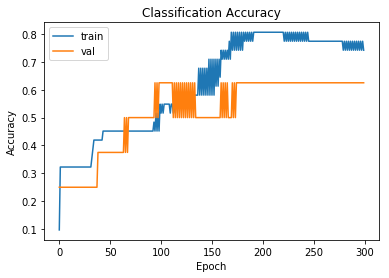

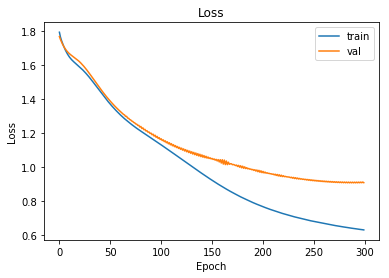

In [17]:
import matplotlib.pyplot as plt


%matplotlib inline

acc_history = history.history['acc']
val_acc_history = history.history['val_acc']
loss_history = history.history['loss']
val_loss_history = history.history['val_loss']

epochs = np.arange(len(acc_history))

plt.plot(epochs, acc_history, label='train')
plt.plot(epochs, val_acc_history, label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Classification Accuracy')
plt.legend()
plt.show()


plt.plot(epochs, loss_history, label='train')
plt.plot(epochs, val_loss_history, label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.show()

In [ ]:
%%time

from sklearn.model_selection import RepeatedStratifiedKFold

n_splits = 3
n_repeats = 20
n_total = n_splits * n_repeats
cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)

score_history = []

print('Fitting %d folds over %d repetitions for a total of %d fits.' % (n_splits, n_repeats, n_total))

for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    print('\nIteration %d of %d' % (i + 1, n_total))
    
    X_train_cv = X[train_idx]
    y_train_cv = y[train_idx]
    X_test_cv = X[test_idx]
    y_test_cv= y[test_idx]

    # Encoding is not done directly on y so that the k-fold splitter doesn't throw an exception.
    ohe = OneHotEncoder(sparse=False)
    y_train_cv = ohe.fit_transform(y_train_cv)
    y_test_cv = ohe.fit_transform(y_test_cv)
    
    model = get_model() 

    history = model.fit(X_train_cv, y_train_cv,
              epochs=200,
              validation_data=(X_test_cv, y_test_cv))
    
    score_history.append(history.history)

    score = model.evaluate(X_test_cv, y_test_cv, verbose=0)
    print('Test loss: %.2f' % score[0])
    print('Test accuracy: %.2f' % score[1])
    
# print('Average score over %d folds and %d repeats: %.2f' % (n_splits, n_repeats, score_history.mean()))

Fitting 3 folds over 20 repetitions for a total of 60 fits.

Iteration 1 of 60
Train on 25 samples, validate on 14 samples
Epoch 1/200
25/25 [==============================] - 1s 41ms/step - loss: 1.7987 - acc: 0.1600 - val_loss: 1.7795 - val_acc: 0.2143
Epoch 2/200
25/25 [==============================] - 0s 7ms/step - loss: 1.7742 - acc: 0.3200 - val_loss: 1.7619 - val_acc: 0.2857
Epoch 3/200
25/25 [==============================] - 0s 8ms/step - loss: 1.7567 - acc: 0.3200 - val_loss: 1.7463 - val_acc: 0.2857
Epoch 4/200
25/25 [==============================] - 0s 7ms/step - loss: 1.7411 - acc: 0.3200 - val_loss: 1.7316 - val_acc: 0.2857
Epoch 5/200
25/25 [==============================] - 0s 8ms/step - loss: 1.7266 - acc: 0.3200 - val_loss: 1.7177 - val_acc: 0.2857
Epoch 6/200
25/25 [==============================] - 0s 8ms/step - loss: 1.7127 - acc: 0.3200 - val_loss: 1.7045 - val_acc: 0.2857
Epoch 7/200
25/25 [==============================] - 0s 8ms/step - loss: 1.6997 - acc: 0.3

Epoch 63/200
25/25 [==============================] - 0s 8ms/step - loss: 1.3223 - acc: 0.4800 - val_loss: 1.2437 - val_acc: 0.4286
Epoch 64/200
25/25 [==============================] - 0s 8ms/step - loss: 1.3164 - acc: 0.4800 - val_loss: 1.2375 - val_acc: 0.4286
Epoch 65/200
25/25 [==============================] - 0s 7ms/step - loss: 1.3106 - acc: 0.4800 - val_loss: 1.2315 - val_acc: 0.4286
Epoch 66/200
25/25 [==============================] - 0s 7ms/step - loss: 1.3049 - acc: 0.4800 - val_loss: 1.2258 - val_acc: 0.4286
Epoch 67/200
25/25 [==============================] - 0s 8ms/step - loss: 1.2993 - acc: 0.4800 - val_loss: 1.2203 - val_acc: 0.4286
Epoch 68/200
25/25 [==============================] - 0s 7ms/step - loss: 1.2942 - acc: 0.4800 - val_loss: 1.2166 - val_acc: 0.4286
Epoch 69/200
25/25 [==============================] - 0s 7ms/step - loss: 1.2894 - acc: 0.4800 - val_loss: 1.2097 - val_acc: 0.4286
Epoch 70/200
25/25 [==============================] - 0s 7ms/step - loss: 1.

Epoch 125/200
25/25 [==============================] - 0s 9ms/step - loss: 1.0062 - acc: 0.6000 - val_loss: 1.0372 - val_acc: 0.5714
Epoch 126/200
25/25 [==============================] - 0s 9ms/step - loss: 1.0010 - acc: 0.6000 - val_loss: 1.0400 - val_acc: 0.5714
Epoch 127/200
25/25 [==============================] - 0s 8ms/step - loss: 0.9956 - acc: 0.6000 - val_loss: 1.0335 - val_acc: 0.5714
Epoch 128/200
25/25 [==============================] - 0s 8ms/step - loss: 0.9903 - acc: 0.6000 - val_loss: 1.0349 - val_acc: 0.5714
Epoch 129/200
25/25 [==============================] - 0s 8ms/step - loss: 0.9850 - acc: 0.5600 - val_loss: 1.0298 - val_acc: 0.5714
Epoch 130/200
25/25 [==============================] - 0s 7ms/step - loss: 0.9798 - acc: 0.6000 - val_loss: 1.0304 - val_acc: 0.5714
Epoch 131/200
25/25 [==============================] - 0s 7ms/step - loss: 0.9746 - acc: 0.5600 - val_loss: 1.0260 - val_acc: 0.5714
Epoch 132/200
25/25 [==============================] - 0s 10ms/step -

Epoch 187/200
25/25 [==============================] - 0s 8ms/step - loss: 0.7408 - acc: 0.6400 - val_loss: 0.9451 - val_acc: 0.5714
Epoch 188/200
25/25 [==============================] - 0s 9ms/step - loss: 0.7376 - acc: 0.6400 - val_loss: 0.9526 - val_acc: 0.5714
Epoch 189/200
25/25 [==============================] - 0s 7ms/step - loss: 0.7343 - acc: 0.6400 - val_loss: 0.9440 - val_acc: 0.5714
Epoch 190/200
25/25 [==============================] - 0s 8ms/step - loss: 0.7312 - acc: 0.6400 - val_loss: 0.9523 - val_acc: 0.5714
Epoch 191/200
25/25 [==============================] - 0s 8ms/step - loss: 0.7279 - acc: 0.6400 - val_loss: 0.9432 - val_acc: 0.5714
Epoch 192/200
25/25 [==============================] - 0s 7ms/step - loss: 0.7247 - acc: 0.6400 - val_loss: 0.9518 - val_acc: 0.5714
Epoch 193/200
25/25 [==============================] - 0s 8ms/step - loss: 0.7214 - acc: 0.6400 - val_loss: 0.9426 - val_acc: 0.5714
Epoch 194/200
25/25 [==============================] - 0s 7ms/step - 

Epoch 49/200
25/25 [==============================] - 0s 6ms/step - loss: 1.2808 - acc: 0.4800 - val_loss: 1.4943 - val_acc: 0.3571
Epoch 50/200
25/25 [==============================] - 0s 7ms/step - loss: 1.2719 - acc: 0.4800 - val_loss: 1.4905 - val_acc: 0.3571
Epoch 51/200
25/25 [==============================] - 0s 10ms/step - loss: 1.2633 - acc: 0.4800 - val_loss: 1.4869 - val_acc: 0.3571
Epoch 52/200
25/25 [==============================] - 0s 7ms/step - loss: 1.2548 - acc: 0.4800 - val_loss: 1.4836 - val_acc: 0.3571
Epoch 53/200
25/25 [==============================] - 0s 6ms/step - loss: 1.2464 - acc: 0.4800 - val_loss: 1.4804 - val_acc: 0.3571
Epoch 54/200
25/25 [==============================] - 0s 8ms/step - loss: 1.2382 - acc: 0.4800 - val_loss: 1.4773 - val_acc: 0.3571
Epoch 55/200
25/25 [==============================] - 0s 6ms/step - loss: 1.2301 - acc: 0.4800 - val_loss: 1.4745 - val_acc: 0.3571
Epoch 56/200
25/25 [==============================] - 0s 8ms/step - loss: 1

Epoch 111/200
25/25 [==============================] - 0s 9ms/step - loss: 0.9278 - acc: 0.6800 - val_loss: 1.4762 - val_acc: 0.5000
Epoch 112/200
25/25 [==============================] - 0s 8ms/step - loss: 0.9238 - acc: 0.7600 - val_loss: 1.5047 - val_acc: 0.2857
Epoch 113/200
25/25 [==============================] - 0s 13ms/step - loss: 0.9198 - acc: 0.6800 - val_loss: 1.4788 - val_acc: 0.5000
Epoch 114/200
25/25 [==============================] - 0s 11ms/step - loss: 0.9158 - acc: 0.7600 - val_loss: 1.5100 - val_acc: 0.2857
Epoch 115/200
25/25 [==============================] - 0s 11ms/step - loss: 0.9118 - acc: 0.6800 - val_loss: 1.4826 - val_acc: 0.5000
Epoch 116/200
25/25 [==============================] - 0s 9ms/step - loss: 0.9078 - acc: 0.7600 - val_loss: 1.5142 - val_acc: 0.2857
Epoch 117/200
25/25 [==============================] - 0s 7ms/step - loss: 0.9038 - acc: 0.7200 - val_loss: 1.4878 - val_acc: 0.5000
Epoch 118/200
25/25 [==============================] - 0s 11ms/ste

Epoch 173/200
25/25 [==============================] - 0s 8ms/step - loss: 0.7020 - acc: 0.7600 - val_loss: 1.7287 - val_acc: 0.5000
Epoch 174/200
25/25 [==============================] - 0s 8ms/step - loss: 0.6990 - acc: 0.7600 - val_loss: 1.7753 - val_acc: 0.5000
Epoch 175/200
25/25 [==============================] - 0s 7ms/step - loss: 0.6960 - acc: 0.7600 - val_loss: 1.7410 - val_acc: 0.5000
Epoch 176/200
25/25 [==============================] - 0s 8ms/step - loss: 0.6930 - acc: 0.8000 - val_loss: 1.7886 - val_acc: 0.5000
Epoch 177/200
25/25 [==============================] - 0s 9ms/step - loss: 0.6900 - acc: 0.7600 - val_loss: 1.7534 - val_acc: 0.5000
Epoch 178/200
25/25 [==============================] - 0s 8ms/step - loss: 0.6870 - acc: 0.8000 - val_loss: 1.8020 - val_acc: 0.5000
Epoch 179/200
25/25 [==============================] - 0s 7ms/step - loss: 0.6841 - acc: 0.7600 - val_loss: 1.7659 - val_acc: 0.5000
Epoch 180/200
25/25 [==============================] - 0s 8ms/step - 

28/28 [==============================] - 0s 6ms/step - loss: 1.4990 - acc: 0.3571 - val_loss: 1.4824 - val_acc: 0.4545
Epoch 35/200
28/28 [==============================] - 0s 7ms/step - loss: 1.4912 - acc: 0.3929 - val_loss: 1.4753 - val_acc: 0.4545
Epoch 36/200
28/28 [==============================] - 0s 6ms/step - loss: 1.4834 - acc: 0.3929 - val_loss: 1.4682 - val_acc: 0.4545
Epoch 37/200
28/28 [==============================] - 0s 6ms/step - loss: 1.4757 - acc: 0.4286 - val_loss: 1.4611 - val_acc: 0.4545
Epoch 38/200
28/28 [==============================] - 0s 9ms/step - loss: 1.4680 - acc: 0.3571 - val_loss: 1.4540 - val_acc: 0.4545
Epoch 39/200
28/28 [==============================] - 0s 6ms/step - loss: 1.4604 - acc: 0.3929 - val_loss: 1.4469 - val_acc: 0.4545
Epoch 40/200
28/28 [==============================] - 0s 7ms/step - loss: 1.4528 - acc: 0.3929 - val_loss: 1.4399 - val_acc: 0.4545
Epoch 41/200
28/28 [==============================] - 0s 7ms/step - loss: 1.4453 - acc: 0

Epoch 97/200
28/28 [==============================] - 0s 11ms/step - loss: 1.1378 - acc: 0.6429 - val_loss: 1.1957 - val_acc: 0.5455
Epoch 98/200
28/28 [==============================] - 0s 14ms/step - loss: 1.1333 - acc: 0.6786 - val_loss: 1.1669 - val_acc: 0.5455
Epoch 99/200
28/28 [==============================] - 0s 11ms/step - loss: 1.1288 - acc: 0.6429 - val_loss: 1.1925 - val_acc: 0.5455
Epoch 100/200
28/28 [==============================] - 0s 10ms/step - loss: 1.1244 - acc: 0.6786 - val_loss: 1.1603 - val_acc: 0.5455
Epoch 101/200
28/28 [==============================] - 0s 7ms/step - loss: 1.1200 - acc: 0.6429 - val_loss: 1.1896 - val_acc: 0.5455
Epoch 102/200
28/28 [==============================] - 0s 7ms/step - loss: 1.1156 - acc: 0.6786 - val_loss: 1.1544 - val_acc: 0.5455
Epoch 103/200
28/28 [==============================] - 0s 8ms/step - loss: 1.1112 - acc: 0.6429 - val_loss: 1.1857 - val_acc: 0.5455
Epoch 104/200
28/28 [==============================] - 0s 9ms/step -

Epoch 159/200
28/28 [==============================] - 0s 6ms/step - loss: 0.8880 - acc: 0.7500 - val_loss: 1.1270 - val_acc: 0.5455
Epoch 160/200
28/28 [==============================] - 0s 6ms/step - loss: 0.8845 - acc: 0.7500 - val_loss: 1.0687 - val_acc: 0.5455
Epoch 161/200
28/28 [==============================] - 0s 6ms/step - loss: 0.8812 - acc: 0.7500 - val_loss: 1.1265 - val_acc: 0.5455
Epoch 162/200
28/28 [==============================] - 0s 6ms/step - loss: 0.8778 - acc: 0.7500 - val_loss: 1.0675 - val_acc: 0.5455
Epoch 163/200
28/28 [==============================] - 0s 6ms/step - loss: 0.8745 - acc: 0.7500 - val_loss: 1.1262 - val_acc: 0.5455
Epoch 164/200
28/28 [==============================] - 0s 7ms/step - loss: 0.8711 - acc: 0.7500 - val_loss: 1.0664 - val_acc: 0.5455
Epoch 165/200
28/28 [==============================] - 0s 7ms/step - loss: 0.8679 - acc: 0.7500 - val_loss: 1.1261 - val_acc: 0.5455
Epoch 166/200
28/28 [==============================] - 0s 7ms/step - 

Epoch 20/200
25/25 [==============================] - 0s 7ms/step - loss: 1.5890 - acc: 0.3200 - val_loss: 1.6096 - val_acc: 0.2857
Epoch 21/200
25/25 [==============================] - 0s 9ms/step - loss: 1.5838 - acc: 0.3200 - val_loss: 1.6041 - val_acc: 0.2857
Epoch 22/200
25/25 [==============================] - 0s 8ms/step - loss: 1.5785 - acc: 0.3200 - val_loss: 1.5984 - val_acc: 0.2857
Epoch 23/200
25/25 [==============================] - 0s 9ms/step - loss: 1.5729 - acc: 0.3200 - val_loss: 1.5923 - val_acc: 0.2857
Epoch 24/200
25/25 [==============================] - 0s 10ms/step - loss: 1.5671 - acc: 0.3200 - val_loss: 1.5860 - val_acc: 0.2857
Epoch 25/200
25/25 [==============================] - 0s 8ms/step - loss: 1.5611 - acc: 0.3200 - val_loss: 1.5795 - val_acc: 0.2857
Epoch 26/200
25/25 [==============================] - 0s 8ms/step - loss: 1.5549 - acc: 0.3200 - val_loss: 1.5726 - val_acc: 0.2857
Epoch 27/200
25/25 [==============================] - 0s 7ms/step - loss: 1

Epoch 82/200
25/25 [==============================] - 0s 8ms/step - loss: 1.1953 - acc: 0.5600 - val_loss: 1.2237 - val_acc: 0.4286
Epoch 83/200
25/25 [==============================] - 0s 8ms/step - loss: 1.1898 - acc: 0.4800 - val_loss: 1.2233 - val_acc: 0.5714
Epoch 84/200
25/25 [==============================] - 0s 10ms/step - loss: 1.1842 - acc: 0.5200 - val_loss: 1.2170 - val_acc: 0.5000
Epoch 85/200
25/25 [==============================] - 0s 9ms/step - loss: 1.1788 - acc: 0.5200 - val_loss: 1.2158 - val_acc: 0.5714
Epoch 86/200
25/25 [==============================] - 0s 10ms/step - loss: 1.1734 - acc: 0.5200 - val_loss: 1.2104 - val_acc: 0.5000
Epoch 87/200
25/25 [==============================] - 0s 10ms/step - loss: 1.1680 - acc: 0.5200 - val_loss: 1.2090 - val_acc: 0.6429
Epoch 88/200
25/25 [==============================] - 0s 9ms/step - loss: 1.1627 - acc: 0.5200 - val_loss: 1.2037 - val_acc: 0.5714
Epoch 89/200
25/25 [==============================] - 0s 8ms/step - loss:

Epoch 144/200
25/25 [==============================] - 0s 8ms/step - loss: 0.8646 - acc: 0.8000 - val_loss: 1.0565 - val_acc: 0.6429
Epoch 145/200
25/25 [==============================] - 0s 9ms/step - loss: 0.8596 - acc: 0.7600 - val_loss: 1.0562 - val_acc: 0.5714
Epoch 146/200
25/25 [==============================] - 0s 11ms/step - loss: 0.8546 - acc: 0.8000 - val_loss: 1.0522 - val_acc: 0.6429
Epoch 147/200
25/25 [==============================] - 0s 12ms/step - loss: 0.8496 - acc: 0.7600 - val_loss: 1.0519 - val_acc: 0.5714
Epoch 148/200
25/25 [==============================] - 0s 7ms/step - loss: 0.8447 - acc: 0.8000 - val_loss: 1.0481 - val_acc: 0.6429
Epoch 149/200
25/25 [==============================] - 0s 9ms/step - loss: 0.8397 - acc: 0.7600 - val_loss: 1.0477 - val_acc: 0.5714
Epoch 150/200
25/25 [==============================] - 0s 9ms/step - loss: 0.8348 - acc: 0.8000 - val_loss: 1.0441 - val_acc: 0.6429
Epoch 151/200
25/25 [==============================] - 0s 8ms/step 

Epoch 5/200
25/25 [==============================] - 0s 7ms/step - loss: 1.7045 - acc: 0.3200 - val_loss: 1.6999 - val_acc: 0.2857
Epoch 6/200
25/25 [==============================] - 0s 7ms/step - loss: 1.6888 - acc: 0.3200 - val_loss: 1.6890 - val_acc: 0.2857
Epoch 7/200
25/25 [==============================] - 0s 7ms/step - loss: 1.6748 - acc: 0.3200 - val_loss: 1.6799 - val_acc: 0.2857
Epoch 8/200
25/25 [==============================] - 0s 8ms/step - loss: 1.6624 - acc: 0.3200 - val_loss: 1.6724 - val_acc: 0.2857
Epoch 9/200
25/25 [==============================] - 0s 7ms/step - loss: 1.6517 - acc: 0.3200 - val_loss: 1.6664 - val_acc: 0.2857
Epoch 10/200
25/25 [==============================] - 0s 7ms/step - loss: 1.6426 - acc: 0.3200 - val_loss: 1.6616 - val_acc: 0.2857
Epoch 11/200
25/25 [==============================] - 0s 7ms/step - loss: 1.6349 - acc: 0.3200 - val_loss: 1.6576 - val_acc: 0.2857
Epoch 12/200
25/25 [==============================] - 0s 8ms/step - loss: 1.6283 

Epoch 68/200
25/25 [==============================] - 0s 11ms/step - loss: 1.2064 - acc: 0.4800 - val_loss: 1.4207 - val_acc: 0.4286
Epoch 69/200
25/25 [==============================] - 0s 10ms/step - loss: 1.2003 - acc: 0.4800 - val_loss: 1.4177 - val_acc: 0.4286
Epoch 70/200
25/25 [==============================] - 0s 7ms/step - loss: 1.1942 - acc: 0.4800 - val_loss: 1.4195 - val_acc: 0.4286
Epoch 71/200
25/25 [==============================] - 0s 9ms/step - loss: 1.1883 - acc: 0.4800 - val_loss: 1.4161 - val_acc: 0.4286
Epoch 72/200
25/25 [==============================] - 0s 6ms/step - loss: 1.1825 - acc: 0.4800 - val_loss: 1.4195 - val_acc: 0.4286
Epoch 73/200
25/25 [==============================] - 0s 9ms/step - loss: 1.1768 - acc: 0.4800 - val_loss: 1.4143 - val_acc: 0.4286
Epoch 74/200
25/25 [==============================] - 0s 8ms/step - loss: 1.1712 - acc: 0.4800 - val_loss: 1.4215 - val_acc: 0.4286
Epoch 75/200
25/25 [==============================] - 0s 7ms/step - loss: 

Epoch 130/200
25/25 [==============================] - 0s 6ms/step - loss: 0.9530 - acc: 0.6400 - val_loss: 1.5357 - val_acc: 0.4286
Epoch 131/200
25/25 [==============================] - 0s 6ms/step - loss: 0.9502 - acc: 0.6400 - val_loss: 1.5191 - val_acc: 0.5714
Epoch 132/200
25/25 [==============================] - 0s 7ms/step - loss: 0.9474 - acc: 0.6400 - val_loss: 1.5423 - val_acc: 0.5000
Epoch 133/200
25/25 [==============================] - 0s 7ms/step - loss: 0.9446 - acc: 0.6400 - val_loss: 1.5250 - val_acc: 0.5714
Epoch 134/200
25/25 [==============================] - 0s 7ms/step - loss: 0.9418 - acc: 0.6400 - val_loss: 1.5489 - val_acc: 0.5000
Epoch 135/200
25/25 [==============================] - 0s 7ms/step - loss: 0.9391 - acc: 0.6400 - val_loss: 1.5312 - val_acc: 0.5714
Epoch 136/200
25/25 [==============================] - 0s 7ms/step - loss: 0.9364 - acc: 0.6400 - val_loss: 1.5553 - val_acc: 0.5000
Epoch 137/200
25/25 [==============================] - 0s 7ms/step - 

Epoch 192/200
25/25 [==============================] - 0s 10ms/step - loss: 0.8133 - acc: 0.6400 - val_loss: 1.7403 - val_acc: 0.5714
Epoch 193/200
25/25 [==============================] - 0s 8ms/step - loss: 0.8116 - acc: 0.6400 - val_loss: 1.7205 - val_acc: 0.6429
Epoch 194/200
25/25 [==============================] - 0s 9ms/step - loss: 0.8098 - acc: 0.6400 - val_loss: 1.7471 - val_acc: 0.5714
Epoch 195/200
25/25 [==============================] - 0s 7ms/step - loss: 0.8081 - acc: 0.6400 - val_loss: 1.7274 - val_acc: 0.6429
Epoch 196/200
25/25 [==============================] - 0s 7ms/step - loss: 0.8063 - acc: 0.6400 - val_loss: 1.7539 - val_acc: 0.5714
Epoch 197/200
25/25 [==============================] - 0s 7ms/step - loss: 0.8046 - acc: 0.6400 - val_loss: 1.7344 - val_acc: 0.6429
Epoch 198/200
25/25 [==============================] - 0s 8ms/step - loss: 0.8029 - acc: 0.6400 - val_loss: 1.7608 - val_acc: 0.5714
Epoch 199/200
25/25 [==============================] - 0s 8ms/step -

Epoch 54/200
28/28 [==============================] - 0s 6ms/step - loss: 1.3451 - acc: 0.4643 - val_loss: 1.3306 - val_acc: 0.4545
Epoch 55/200
28/28 [==============================] - 0s 7ms/step - loss: 1.3379 - acc: 0.4643 - val_loss: 1.3233 - val_acc: 0.4545
Epoch 56/200
28/28 [==============================] - 0s 6ms/step - loss: 1.3307 - acc: 0.4643 - val_loss: 1.3160 - val_acc: 0.4545
Epoch 57/200
28/28 [==============================] - 0s 7ms/step - loss: 1.3237 - acc: 0.4643 - val_loss: 1.3087 - val_acc: 0.4545
Epoch 58/200
28/28 [==============================] - 0s 7ms/step - loss: 1.3168 - acc: 0.4643 - val_loss: 1.3016 - val_acc: 0.4545
Epoch 59/200
28/28 [==============================] - 0s 7ms/step - loss: 1.3101 - acc: 0.4643 - val_loss: 1.2945 - val_acc: 0.5455
Epoch 60/200
28/28 [==============================] - 0s 7ms/step - loss: 1.3034 - acc: 0.4643 - val_loss: 1.2876 - val_acc: 0.5455
Epoch 61/200
28/28 [==============================] - 0s 7ms/step - loss: 1.

Epoch 116/200
28/28 [==============================] - 0s 6ms/step - loss: 1.0390 - acc: 0.6071 - val_loss: 1.0503 - val_acc: 0.5455
Epoch 117/200
28/28 [==============================] - 0s 7ms/step - loss: 1.0352 - acc: 0.6429 - val_loss: 1.0404 - val_acc: 0.6364
Epoch 118/200
28/28 [==============================] - 0s 6ms/step - loss: 1.0315 - acc: 0.6071 - val_loss: 1.0460 - val_acc: 0.5455
Epoch 119/200
28/28 [==============================] - 0s 7ms/step - loss: 1.0278 - acc: 0.6429 - val_loss: 1.0361 - val_acc: 0.6364
Epoch 120/200
28/28 [==============================] - 0s 6ms/step - loss: 1.0241 - acc: 0.6071 - val_loss: 1.0417 - val_acc: 0.5455
Epoch 121/200
28/28 [==============================] - 0s 6ms/step - loss: 1.0205 - acc: 0.6429 - val_loss: 1.0322 - val_acc: 0.6364
Epoch 122/200
28/28 [==============================] - 0s 6ms/step - loss: 1.0168 - acc: 0.6071 - val_loss: 1.0374 - val_acc: 0.5455
Epoch 123/200
28/28 [==============================] - 0s 6ms/step - 

Epoch 178/200
28/28 [==============================] - 0s 8ms/step - loss: 0.8361 - acc: 0.6429 - val_loss: 0.9739 - val_acc: 0.6364
Epoch 179/200
28/28 [==============================] - 0s 8ms/step - loss: 0.8334 - acc: 0.6786 - val_loss: 0.9728 - val_acc: 0.7273
Epoch 180/200
28/28 [==============================] - 0s 8ms/step - loss: 0.8307 - acc: 0.6429 - val_loss: 0.9733 - val_acc: 0.6364
Epoch 181/200
28/28 [==============================] - 0s 9ms/step - loss: 0.8281 - acc: 0.6786 - val_loss: 0.9715 - val_acc: 0.7273
Epoch 182/200
28/28 [==============================] - 0s 8ms/step - loss: 0.8255 - acc: 0.6429 - val_loss: 0.9727 - val_acc: 0.6364
Epoch 183/200
28/28 [==============================] - 0s 11ms/step - loss: 0.8229 - acc: 0.6786 - val_loss: 0.9704 - val_acc: 0.7273
Epoch 184/200
28/28 [==============================] - 0s 8ms/step - loss: 0.8202 - acc: 0.6786 - val_loss: 0.9714 - val_acc: 0.6364
Epoch 185/200
28/28 [==============================] - 0s 10ms/step 

25/25 [==============================] - 0s 9ms/step - loss: 1.4345 - acc: 0.4400 - val_loss: 1.4778 - val_acc: 0.3571
Epoch 40/200
25/25 [==============================] - 0s 9ms/step - loss: 1.4260 - acc: 0.4800 - val_loss: 1.4699 - val_acc: 0.3571
Epoch 41/200
25/25 [==============================] - 0s 9ms/step - loss: 1.4176 - acc: 0.4800 - val_loss: 1.4620 - val_acc: 0.3571
Epoch 42/200
25/25 [==============================] - 0s 10ms/step - loss: 1.4092 - acc: 0.4800 - val_loss: 1.4542 - val_acc: 0.3571
Epoch 43/200
25/25 [==============================] - 0s 10ms/step - loss: 1.4010 - acc: 0.4400 - val_loss: 1.4465 - val_acc: 0.3571
Epoch 44/200
25/25 [==============================] - 0s 10ms/step - loss: 1.3929 - acc: 0.4400 - val_loss: 1.4389 - val_acc: 0.3571
Epoch 45/200
25/25 [==============================] - 0s 9ms/step - loss: 1.3849 - acc: 0.4800 - val_loss: 1.4314 - val_acc: 0.3571
Epoch 46/200
25/25 [==============================] - 0s 12ms/step - loss: 1.3770 - ac

Epoch 101/200
25/25 [==============================] - 0s 11ms/step - loss: 1.0901 - acc: 0.6000 - val_loss: 1.1680 - val_acc: 0.4286
Epoch 102/200
25/25 [==============================] - 0s 10ms/step - loss: 1.0857 - acc: 0.6000 - val_loss: 1.1720 - val_acc: 0.5000
Epoch 103/200
25/25 [==============================] - 0s 13ms/step - loss: 1.0814 - acc: 0.6000 - val_loss: 1.1624 - val_acc: 0.5000
Epoch 104/200
25/25 [==============================] - 0s 10ms/step - loss: 1.0770 - acc: 0.6000 - val_loss: 1.1655 - val_acc: 0.5000
Epoch 105/200
25/25 [==============================] - 0s 12ms/step - loss: 1.0726 - acc: 0.6000 - val_loss: 1.1566 - val_acc: 0.5000
Epoch 106/200
25/25 [==============================] - 0s 9ms/step - loss: 1.0683 - acc: 0.6000 - val_loss: 1.1595 - val_acc: 0.5000
Epoch 107/200
25/25 [==============================] - 0s 8ms/step - loss: 1.0639 - acc: 0.6000 - val_loss: 1.1507 - val_acc: 0.5000
Epoch 108/200
25/25 [==============================] - 0s 11ms/s

Epoch 163/200
25/25 [==============================] - 0s 11ms/step - loss: 0.8410 - acc: 0.7600 - val_loss: 1.0098 - val_acc: 0.5000
Epoch 164/200
25/25 [==============================] - 0s 9ms/step - loss: 0.8378 - acc: 0.7200 - val_loss: 1.0061 - val_acc: 0.5000
Epoch 165/200
25/25 [==============================] - 0s 13ms/step - loss: 0.8345 - acc: 0.7600 - val_loss: 1.0058 - val_acc: 0.5000
Epoch 166/200
25/25 [==============================] - 0s 13ms/step - loss: 0.8313 - acc: 0.7200 - val_loss: 1.0015 - val_acc: 0.5000
Epoch 167/200
25/25 [==============================] - 0s 9ms/step - loss: 0.8282 - acc: 0.7600 - val_loss: 1.0019 - val_acc: 0.5000
Epoch 168/200
25/25 [==============================] - 0s 10ms/step - loss: 0.8250 - acc: 0.7200 - val_loss: 0.9970 - val_acc: 0.5000
Epoch 169/200
25/25 [==============================] - 0s 9ms/step - loss: 0.8219 - acc: 0.7600 - val_loss: 0.9981 - val_acc: 0.5000
Epoch 170/200
25/25 [==============================] - 0s 10ms/st

Epoch 24/200
25/25 [==============================] - 0s 14ms/step - loss: 1.5885 - acc: 0.3200 - val_loss: 1.5791 - val_acc: 0.2857
Epoch 25/200
25/25 [==============================] - 0s 12ms/step - loss: 1.5833 - acc: 0.3200 - val_loss: 1.5725 - val_acc: 0.2857
Epoch 26/200
25/25 [==============================] - 0s 12ms/step - loss: 1.5779 - acc: 0.3200 - val_loss: 1.5657 - val_acc: 0.2857
Epoch 27/200
25/25 [==============================] - 0s 14ms/step - loss: 1.5724 - acc: 0.3200 - val_loss: 1.5586 - val_acc: 0.2857
Epoch 28/200
25/25 [==============================] - 0s 10ms/step - loss: 1.5667 - acc: 0.3200 - val_loss: 1.5512 - val_acc: 0.2857
Epoch 29/200
25/25 [==============================] - 0s 13ms/step - loss: 1.5608 - acc: 0.3200 - val_loss: 1.5437 - val_acc: 0.2857
Epoch 30/200
25/25 [==============================] - 0s 12ms/step - loss: 1.5547 - acc: 0.3200 - val_loss: 1.5359 - val_acc: 0.2857
Epoch 31/200
25/25 [==============================] - 0s 11ms/step - 

Epoch 86/200
25/25 [==============================] - 0s 12ms/step - loss: 1.2198 - acc: 0.4800 - val_loss: 1.1482 - val_acc: 0.4286
Epoch 87/200
25/25 [==============================] - 0s 13ms/step - loss: 1.2147 - acc: 0.4800 - val_loss: 1.1452 - val_acc: 0.4286
Epoch 88/200
25/25 [==============================] - 0s 10ms/step - loss: 1.2097 - acc: 0.4800 - val_loss: 1.1399 - val_acc: 0.4286
Epoch 89/200
25/25 [==============================] - 0s 10ms/step - loss: 1.2047 - acc: 0.4800 - val_loss: 1.1370 - val_acc: 0.4286
Epoch 90/200
25/25 [==============================] - 0s 11ms/step - loss: 1.1998 - acc: 0.4800 - val_loss: 1.1317 - val_acc: 0.4286
Epoch 91/200
25/25 [==============================] - 0s 11ms/step - loss: 1.1948 - acc: 0.4800 - val_loss: 1.1292 - val_acc: 0.4286
Epoch 92/200
25/25 [==============================] - 0s 10ms/step - loss: 1.1899 - acc: 0.4800 - val_loss: 1.1237 - val_acc: 0.5000
Epoch 93/200
25/25 [==============================] - 0s 11ms/step - 

Epoch 148/200
25/25 [==============================] - 0s 9ms/step - loss: 0.9218 - acc: 0.6800 - val_loss: 0.9602 - val_acc: 0.7143
Epoch 149/200
25/25 [==============================] - 0s 13ms/step - loss: 0.9175 - acc: 0.6800 - val_loss: 0.9660 - val_acc: 0.7143
Epoch 150/200
25/25 [==============================] - 0s 10ms/step - loss: 0.9133 - acc: 0.6800 - val_loss: 0.9561 - val_acc: 0.7143
Epoch 151/200
25/25 [==============================] - 0s 12ms/step - loss: 0.9091 - acc: 0.6800 - val_loss: 0.9613 - val_acc: 0.7143
Epoch 152/200
25/25 [==============================] - 0s 10ms/step - loss: 0.9050 - acc: 0.6800 - val_loss: 0.9522 - val_acc: 0.7143
Epoch 153/200
25/25 [==============================] - 0s 11ms/step - loss: 0.9008 - acc: 0.7200 - val_loss: 0.9566 - val_acc: 0.7143
Epoch 154/200
25/25 [==============================] - 0s 11ms/step - loss: 0.8967 - acc: 0.6800 - val_loss: 0.9480 - val_acc: 0.7143
Epoch 155/200
25/25 [==============================] - 0s 13ms/

Epoch 9/200
28/28 [==============================] - 0s 9ms/step - loss: 1.6616 - acc: 0.2857 - val_loss: 1.6417 - val_acc: 0.3636
Epoch 10/200
28/28 [==============================] - 0s 10ms/step - loss: 1.6519 - acc: 0.2857 - val_loss: 1.6336 - val_acc: 0.3636
Epoch 11/200
28/28 [==============================] - 0s 8ms/step - loss: 1.6431 - acc: 0.2857 - val_loss: 1.6269 - val_acc: 0.3636
Epoch 12/200
28/28 [==============================] - 0s 10ms/step - loss: 1.6350 - acc: 0.2857 - val_loss: 1.6211 - val_acc: 0.3636
Epoch 13/200
28/28 [==============================] - 0s 11ms/step - loss: 1.6274 - acc: 0.2857 - val_loss: 1.6161 - val_acc: 0.3636
Epoch 14/200
28/28 [==============================] - 0s 9ms/step - loss: 1.6199 - acc: 0.2857 - val_loss: 1.6116 - val_acc: 0.3636
Epoch 15/200
28/28 [==============================] - 0s 10ms/step - loss: 1.6126 - acc: 0.2857 - val_loss: 1.6074 - val_acc: 0.3636
Epoch 16/200
28/28 [==============================] - 0s 10ms/step - loss

Epoch 71/200
28/28 [==============================] - 0s 14ms/step - loss: 1.1553 - acc: 0.5714 - val_loss: 1.4734 - val_acc: 0.3636
Epoch 72/200
28/28 [==============================] - 0s 11ms/step - loss: 1.1498 - acc: 0.6071 - val_loss: 1.4772 - val_acc: 0.3636
Epoch 73/200
28/28 [==============================] - 0s 11ms/step - loss: 1.1445 - acc: 0.5714 - val_loss: 1.4750 - val_acc: 0.4545
Epoch 74/200
28/28 [==============================] - 0s 8ms/step - loss: 1.1392 - acc: 0.6071 - val_loss: 1.4823 - val_acc: 0.3636
Epoch 75/200
28/28 [==============================] - 0s 10ms/step - loss: 1.1342 - acc: 0.5714 - val_loss: 1.4763 - val_acc: 0.4545
Epoch 76/200
28/28 [==============================] - 0s 9ms/step - loss: 1.1294 - acc: 0.6071 - val_loss: 1.4884 - val_acc: 0.3636
Epoch 77/200
28/28 [==============================] - 0s 9ms/step - loss: 1.1247 - acc: 0.6071 - val_loss: 1.4794 - val_acc: 0.4545
Epoch 78/200
28/28 [==============================] - 0s 9ms/step - loss

Epoch 133/200
28/28 [==============================] - 0s 10ms/step - loss: 0.9137 - acc: 0.6071 - val_loss: 1.6517 - val_acc: 0.5455
Epoch 134/200
28/28 [==============================] - 0s 9ms/step - loss: 0.9106 - acc: 0.6429 - val_loss: 1.6665 - val_acc: 0.5455
Epoch 135/200
28/28 [==============================] - 0s 11ms/step - loss: 0.9075 - acc: 0.6071 - val_loss: 1.6584 - val_acc: 0.5455
Epoch 136/200
28/28 [==============================] - 0s 9ms/step - loss: 0.9043 - acc: 0.6429 - val_loss: 1.6730 - val_acc: 0.5455
Epoch 137/200
28/28 [==============================] - 0s 9ms/step - loss: 0.9012 - acc: 0.6071 - val_loss: 1.6654 - val_acc: 0.5455
Epoch 138/200
28/28 [==============================] - 0s 9ms/step - loss: 0.8981 - acc: 0.6071 - val_loss: 1.6793 - val_acc: 0.5455
Epoch 139/200
28/28 [==============================] - 0s 9ms/step - loss: 0.8951 - acc: 0.6071 - val_loss: 1.6726 - val_acc: 0.5455
Epoch 140/200
28/28 [==============================] - 0s 11ms/step

Epoch 195/200
28/28 [==============================] - 0s 11ms/step - loss: 0.7510 - acc: 0.6429 - val_loss: 1.9540 - val_acc: 0.6364
Epoch 196/200
28/28 [==============================] - 0s 11ms/step - loss: 0.7490 - acc: 0.7143 - val_loss: 1.9499 - val_acc: 0.5455
Epoch 197/200
28/28 [==============================] - 0s 10ms/step - loss: 0.7470 - acc: 0.6429 - val_loss: 1.9677 - val_acc: 0.6364
Epoch 198/200
28/28 [==============================] - 0s 9ms/step - loss: 0.7450 - acc: 0.6786 - val_loss: 1.9631 - val_acc: 0.5455
Epoch 199/200
28/28 [==============================] - 0s 12ms/step - loss: 0.7430 - acc: 0.6429 - val_loss: 1.9816 - val_acc: 0.6364
Epoch 200/200
28/28 [==============================] - 0s 16ms/step - loss: 0.7411 - acc: 0.6786 - val_loss: 1.9767 - val_acc: 0.5455
Test loss: 1.98
Test accuracy: 0.55

Iteration 10 of 60
Train on 25 samples, validate on 14 samples
Epoch 1/200
25/25 [==============================] - 2s 90ms/step - loss: 1.8034 - acc: 0.0800 - 

Epoch 56/200
25/25 [==============================] - 0s 10ms/step - loss: 1.2875 - acc: 0.4800 - val_loss: 1.4683 - val_acc: 0.4286
Epoch 57/200
25/25 [==============================] - 0s 12ms/step - loss: 1.2785 - acc: 0.4800 - val_loss: 1.4650 - val_acc: 0.4286
Epoch 58/200
25/25 [==============================] - 0s 10ms/step - loss: 1.2697 - acc: 0.4800 - val_loss: 1.4619 - val_acc: 0.4286
Epoch 59/200
25/25 [==============================] - 0s 14ms/step - loss: 1.2610 - acc: 0.4800 - val_loss: 1.4590 - val_acc: 0.4286
Epoch 60/200
25/25 [==============================] - 0s 12ms/step - loss: 1.2524 - acc: 0.4800 - val_loss: 1.4563 - val_acc: 0.4286
Epoch 61/200
25/25 [==============================] - 0s 10ms/step - loss: 1.2439 - acc: 0.4800 - val_loss: 1.4539 - val_acc: 0.4286
Epoch 62/200
25/25 [==============================] - 0s 11ms/step - loss: 1.2355 - acc: 0.4800 - val_loss: 1.4516 - val_acc: 0.4286
Epoch 63/200
25/25 [==============================] - 0s 10ms/step - 

Epoch 118/200
25/25 [==============================] - 0s 12ms/step - loss: 0.9255 - acc: 0.6400 - val_loss: 1.5317 - val_acc: 0.5000
Epoch 119/200
25/25 [==============================] - 0s 9ms/step - loss: 0.9217 - acc: 0.6400 - val_loss: 1.5118 - val_acc: 0.5000
Epoch 120/200
25/25 [==============================] - 0s 10ms/step - loss: 0.9180 - acc: 0.6400 - val_loss: 1.5378 - val_acc: 0.5000
Epoch 121/200
25/25 [==============================] - 0s 10ms/step - loss: 0.9142 - acc: 0.6400 - val_loss: 1.5170 - val_acc: 0.5000
Epoch 122/200
25/25 [==============================] - 0s 12ms/step - loss: 0.9105 - acc: 0.6400 - val_loss: 1.5426 - val_acc: 0.5000
Epoch 123/200
25/25 [==============================] - 0s 11ms/step - loss: 0.9068 - acc: 0.6400 - val_loss: 1.5229 - val_acc: 0.5000
Epoch 124/200
25/25 [==============================] - 0s 10ms/step - loss: 0.9031 - acc: 0.6400 - val_loss: 1.5470 - val_acc: 0.5000
Epoch 125/200
25/25 [==============================] - 0s 11ms/

Epoch 180/200
25/25 [==============================] - 0s 14ms/step - loss: 0.7331 - acc: 0.6400 - val_loss: 1.7208 - val_acc: 0.4286
Epoch 181/200
25/25 [==============================] - 0s 11ms/step - loss: 0.7307 - acc: 0.6400 - val_loss: 1.6818 - val_acc: 0.4286
Epoch 182/200
25/25 [==============================] - 0s 12ms/step - loss: 0.7282 - acc: 0.6400 - val_loss: 1.7282 - val_acc: 0.4286
Epoch 183/200
25/25 [==============================] - 0s 11ms/step - loss: 0.7258 - acc: 0.6800 - val_loss: 1.6886 - val_acc: 0.4286
Epoch 184/200
25/25 [==============================] - 0s 14ms/step - loss: 0.7235 - acc: 0.6400 - val_loss: 1.7357 - val_acc: 0.4286
Epoch 185/200
25/25 [==============================] - 0s 11ms/step - loss: 0.7211 - acc: 0.6800 - val_loss: 1.6955 - val_acc: 0.4286
Epoch 186/200
25/25 [==============================] - 0s 10ms/step - loss: 0.7188 - acc: 0.6400 - val_loss: 1.7434 - val_acc: 0.4286
Epoch 187/200
25/25 [==============================] - 0s 12ms

Epoch 41/200
25/25 [==============================] - 0s 15ms/step - loss: 1.4368 - acc: 0.4400 - val_loss: 1.4526 - val_acc: 0.4286
Epoch 42/200
25/25 [==============================] - 0s 11ms/step - loss: 1.4290 - acc: 0.4400 - val_loss: 1.4437 - val_acc: 0.4286
Epoch 43/200
25/25 [==============================] - 0s 10ms/step - loss: 1.4213 - acc: 0.4800 - val_loss: 1.4348 - val_acc: 0.4286
Epoch 44/200
25/25 [==============================] - 0s 9ms/step - loss: 1.4136 - acc: 0.4800 - val_loss: 1.4260 - val_acc: 0.4286
Epoch 45/200
25/25 [==============================] - 0s 10ms/step - loss: 1.4060 - acc: 0.4800 - val_loss: 1.4172 - val_acc: 0.4286
Epoch 46/200
25/25 [==============================] - 0s 14ms/step - loss: 1.3985 - acc: 0.4800 - val_loss: 1.4086 - val_acc: 0.4286
Epoch 47/200
25/25 [==============================] - 0s 10ms/step - loss: 1.3910 - acc: 0.5200 - val_loss: 1.4000 - val_acc: 0.5000
Epoch 48/200
25/25 [==============================] - 0s 10ms/step - l

Epoch 103/200
25/25 [==============================] - 0s 11ms/step - loss: 1.0838 - acc: 0.6800 - val_loss: 1.0735 - val_acc: 0.5714
Epoch 104/200
25/25 [==============================] - 0s 10ms/step - loss: 1.0789 - acc: 0.6400 - val_loss: 1.0748 - val_acc: 0.5714
Epoch 105/200
25/25 [==============================] - 0s 11ms/step - loss: 1.0739 - acc: 0.6800 - val_loss: 1.0657 - val_acc: 0.5714
Epoch 106/200
25/25 [==============================] - 0s 8ms/step - loss: 1.0690 - acc: 0.6400 - val_loss: 1.0674 - val_acc: 0.5714
Epoch 107/200
25/25 [==============================] - 0s 11ms/step - loss: 1.0641 - acc: 0.6800 - val_loss: 1.0578 - val_acc: 0.5714
Epoch 108/200
25/25 [==============================] - 0s 9ms/step - loss: 1.0592 - acc: 0.6400 - val_loss: 1.0603 - val_acc: 0.6429
Epoch 109/200
25/25 [==============================] - 0s 11ms/step - loss: 1.0543 - acc: 0.6800 - val_loss: 1.0502 - val_acc: 0.5714
Epoch 110/200
25/25 [==============================] - 0s 10ms/s

Epoch 165/200
25/25 [==============================] - 0s 14ms/step - loss: 0.8020 - acc: 0.7600 - val_loss: 0.8985 - val_acc: 0.7143
Epoch 166/200
25/25 [==============================] - 0s 8ms/step - loss: 0.7984 - acc: 0.7600 - val_loss: 0.8848 - val_acc: 0.7143
Epoch 167/200
25/25 [==============================] - 0s 10ms/step - loss: 0.7948 - acc: 0.7600 - val_loss: 0.8956 - val_acc: 0.7143
Epoch 168/200
25/25 [==============================] - 0s 12ms/step - loss: 0.7913 - acc: 0.7600 - val_loss: 0.8807 - val_acc: 0.7143
Epoch 169/200
25/25 [==============================] - 0s 12ms/step - loss: 0.7877 - acc: 0.7600 - val_loss: 0.8928 - val_acc: 0.7143
Epoch 170/200
25/25 [==============================] - 0s 9ms/step - loss: 0.7843 - acc: 0.7600 - val_loss: 0.8770 - val_acc: 0.7143
Epoch 171/200
25/25 [==============================] - 0s 11ms/step - loss: 0.7808 - acc: 0.7600 - val_loss: 0.8897 - val_acc: 0.7143
Epoch 172/200
25/25 [==============================] - 0s 9ms/st

Epoch 26/200
28/28 [==============================] - 0s 10ms/step - loss: 1.5849 - acc: 0.2857 - val_loss: 1.5207 - val_acc: 0.3636
Epoch 27/200
28/28 [==============================] - 0s 9ms/step - loss: 1.5778 - acc: 0.2857 - val_loss: 1.5130 - val_acc: 0.3636
Epoch 28/200
28/28 [==============================] - 0s 10ms/step - loss: 1.5706 - acc: 0.2857 - val_loss: 1.5051 - val_acc: 0.3636
Epoch 29/200
28/28 [==============================] - 0s 8ms/step - loss: 1.5631 - acc: 0.2857 - val_loss: 1.4971 - val_acc: 0.3636
Epoch 30/200
28/28 [==============================] - 0s 10ms/step - loss: 1.5555 - acc: 0.2857 - val_loss: 1.4889 - val_acc: 0.3636
Epoch 31/200
28/28 [==============================] - 0s 8ms/step - loss: 1.5478 - acc: 0.2857 - val_loss: 1.4805 - val_acc: 0.3636
Epoch 32/200
28/28 [==============================] - 0s 10ms/step - loss: 1.5399 - acc: 0.2857 - val_loss: 1.4720 - val_acc: 0.3636
Epoch 33/200
28/28 [==============================] - 0s 12ms/step - los

Epoch 88/200
28/28 [==============================] - 0s 12ms/step - loss: 1.1786 - acc: 0.5000 - val_loss: 1.1233 - val_acc: 0.4545
Epoch 89/200
28/28 [==============================] - 0s 8ms/step - loss: 1.1739 - acc: 0.5357 - val_loss: 1.1285 - val_acc: 0.4545
Epoch 90/200
28/28 [==============================] - 0s 10ms/step - loss: 1.1693 - acc: 0.5357 - val_loss: 1.1174 - val_acc: 0.4545
Epoch 91/200
28/28 [==============================] - 0s 8ms/step - loss: 1.1647 - acc: 0.5357 - val_loss: 1.1242 - val_acc: 0.5455
Epoch 92/200
28/28 [==============================] - 0s 9ms/step - loss: 1.1601 - acc: 0.6071 - val_loss: 1.1110 - val_acc: 0.4545
Epoch 93/200
28/28 [==============================] - 0s 9ms/step - loss: 1.1555 - acc: 0.5357 - val_loss: 1.1210 - val_acc: 0.5455
Epoch 94/200
28/28 [==============================] - 0s 10ms/step - loss: 1.1510 - acc: 0.6071 - val_loss: 1.1045 - val_acc: 0.4545
Epoch 95/200
28/28 [==============================] - 0s 9ms/step - loss:

Epoch 150/200
28/28 [==============================] - 0s 9ms/step - loss: 0.9122 - acc: 0.7143 - val_loss: 1.0164 - val_acc: 0.5455
Epoch 151/200
28/28 [==============================] - 0s 12ms/step - loss: 0.9087 - acc: 0.7143 - val_loss: 1.0387 - val_acc: 0.5455
Epoch 152/200
28/28 [==============================] - 0s 10ms/step - loss: 0.9052 - acc: 0.7143 - val_loss: 1.0147 - val_acc: 0.5455
Epoch 153/200
28/28 [==============================] - 0s 13ms/step - loss: 0.9017 - acc: 0.7143 - val_loss: 1.0374 - val_acc: 0.5455
Epoch 154/200
28/28 [==============================] - 0s 8ms/step - loss: 0.8982 - acc: 0.7143 - val_loss: 1.0132 - val_acc: 0.5455
Epoch 155/200
28/28 [==============================] - 0s 11ms/step - loss: 0.8948 - acc: 0.7500 - val_loss: 1.0364 - val_acc: 0.5455
Epoch 156/200
28/28 [==============================] - 0s 10ms/step - loss: 0.8914 - acc: 0.7143 - val_loss: 1.0117 - val_acc: 0.5455
Epoch 157/200
28/28 [==============================] - 0s 10ms/s

Epoch 11/200
25/25 [==============================] - 0s 12ms/step - loss: 1.6396 - acc: 0.3200 - val_loss: 1.6750 - val_acc: 0.2857
Epoch 12/200
25/25 [==============================] - 0s 9ms/step - loss: 1.6315 - acc: 0.3200 - val_loss: 1.6712 - val_acc: 0.2857
Epoch 13/200
25/25 [==============================] - 0s 11ms/step - loss: 1.6244 - acc: 0.3200 - val_loss: 1.6678 - val_acc: 0.2857
Epoch 14/200
25/25 [==============================] - 0s 9ms/step - loss: 1.6181 - acc: 0.3200 - val_loss: 1.6646 - val_acc: 0.2857
Epoch 15/200
25/25 [==============================] - 0s 16ms/step - loss: 1.6123 - acc: 0.3200 - val_loss: 1.6614 - val_acc: 0.2857
Epoch 16/200
25/25 [==============================] - 0s 11ms/step - loss: 1.6067 - acc: 0.3200 - val_loss: 1.6580 - val_acc: 0.2857
Epoch 17/200
25/25 [==============================] - 0s 12ms/step - loss: 1.6012 - acc: 0.3200 - val_loss: 1.6544 - val_acc: 0.2857
Epoch 18/200
25/25 [==============================] - 0s 11ms/step - lo

Epoch 73/200
25/25 [==============================] - 0s 7ms/step - loss: 1.1625 - acc: 0.4800 - val_loss: 1.4191 - val_acc: 0.4286
Epoch 74/200
25/25 [==============================] - 0s 6ms/step - loss: 1.1567 - acc: 0.5200 - val_loss: 1.4222 - val_acc: 0.4286
Epoch 75/200
25/25 [==============================] - 0s 8ms/step - loss: 1.1512 - acc: 0.4800 - val_loss: 1.4193 - val_acc: 0.3571
Epoch 76/200
25/25 [==============================] - 0s 6ms/step - loss: 1.1457 - acc: 0.5200 - val_loss: 1.4210 - val_acc: 0.3571
Epoch 77/200
25/25 [==============================] - 0s 10ms/step - loss: 1.1404 - acc: 0.5200 - val_loss: 1.4192 - val_acc: 0.3571
Epoch 78/200
25/25 [==============================] - 0s 11ms/step - loss: 1.1352 - acc: 0.5200 - val_loss: 1.4206 - val_acc: 0.3571
Epoch 79/200
25/25 [==============================] - 0s 9ms/step - loss: 1.1300 - acc: 0.5200 - val_loss: 1.4192 - val_acc: 0.3571
Epoch 80/200
25/25 [==============================] - 0s 13ms/step - loss:

Epoch 135/200
25/25 [==============================] - 0s 13ms/step - loss: 0.9071 - acc: 0.6800 - val_loss: 1.5238 - val_acc: 0.6429
Epoch 136/200
25/25 [==============================] - 0s 12ms/step - loss: 0.9036 - acc: 0.6400 - val_loss: 1.5280 - val_acc: 0.6429
Epoch 137/200
25/25 [==============================] - 0s 12ms/step - loss: 0.9001 - acc: 0.6800 - val_loss: 1.5298 - val_acc: 0.6429
Epoch 138/200
25/25 [==============================] - 0s 11ms/step - loss: 0.8967 - acc: 0.6400 - val_loss: 1.5336 - val_acc: 0.6429
Epoch 139/200
25/25 [==============================] - 0s 10ms/step - loss: 0.8932 - acc: 0.6800 - val_loss: 1.5363 - val_acc: 0.6429
Epoch 140/200
25/25 [==============================] - 0s 12ms/step - loss: 0.8898 - acc: 0.6400 - val_loss: 1.5393 - val_acc: 0.6429
Epoch 141/200
25/25 [==============================] - 0s 9ms/step - loss: 0.8864 - acc: 0.6800 - val_loss: 1.5431 - val_acc: 0.6429
Epoch 142/200
25/25 [==============================] - 0s 11ms/

Epoch 197/200
25/25 [==============================] - 0s 15ms/step - loss: 0.7251 - acc: 0.6800 - val_loss: 1.7599 - val_acc: 0.5714
Epoch 198/200
25/25 [==============================] - 0s 10ms/step - loss: 0.7228 - acc: 0.6800 - val_loss: 1.7279 - val_acc: 0.6429
Epoch 199/200
25/25 [==============================] - 0s 10ms/step - loss: 0.7207 - acc: 0.7200 - val_loss: 1.7683 - val_acc: 0.5714
Epoch 200/200
25/25 [==============================] - 0s 12ms/step - loss: 0.7184 - acc: 0.6800 - val_loss: 1.7349 - val_acc: 0.6429
Test loss: 1.73
Test accuracy: 0.64

Iteration 14 of 60
Train on 25 samples, validate on 14 samples
Epoch 1/200
25/25 [==============================] - 3s 105ms/step - loss: 1.7899 - acc: 0.0800 - val_loss: 1.7645 - val_acc: 0.2857
Epoch 2/200
25/25 [==============================] - 0s 10ms/step - loss: 1.7632 - acc: 0.3200 - val_loss: 1.7456 - val_acc: 0.2857
Epoch 3/200
25/25 [==============================] - 0s 12ms/step - loss: 1.7442 - acc: 0.3200 - va

Epoch 58/200
25/25 [==============================] - 0s 11ms/step - loss: 1.3503 - acc: 0.4400 - val_loss: 1.3067 - val_acc: 0.4286
Epoch 59/200
25/25 [==============================] - 0s 12ms/step - loss: 1.3442 - acc: 0.4400 - val_loss: 1.3012 - val_acc: 0.4286
Epoch 60/200
25/25 [==============================] - 0s 8ms/step - loss: 1.3383 - acc: 0.4400 - val_loss: 1.2932 - val_acc: 0.4286
Epoch 61/200
25/25 [==============================] - 0s 11ms/step - loss: 1.3332 - acc: 0.4400 - val_loss: 1.2914 - val_acc: 0.4286
Epoch 62/200
25/25 [==============================] - 0s 10ms/step - loss: 1.3287 - acc: 0.4400 - val_loss: 1.2819 - val_acc: 0.5000
Epoch 63/200
25/25 [==============================] - 0s 12ms/step - loss: 1.3220 - acc: 0.4400 - val_loss: 1.2770 - val_acc: 0.4286
Epoch 64/200
25/25 [==============================] - 0s 9ms/step - loss: 1.3159 - acc: 0.4400 - val_loss: 1.2701 - val_acc: 0.5000
Epoch 65/200
25/25 [==============================] - 0s 9ms/step - los

Epoch 120/200
25/25 [==============================] - 0s 11ms/step - loss: 1.0514 - acc: 0.5600 - val_loss: 1.0812 - val_acc: 0.5000
Epoch 121/200
25/25 [==============================] - 0s 9ms/step - loss: 1.0472 - acc: 0.6400 - val_loss: 1.0842 - val_acc: 0.5000
Epoch 122/200
25/25 [==============================] - 0s 15ms/step - loss: 1.0429 - acc: 0.5600 - val_loss: 1.0775 - val_acc: 0.5000
Epoch 123/200
25/25 [==============================] - 0s 8ms/step - loss: 1.0387 - acc: 0.6400 - val_loss: 1.0812 - val_acc: 0.5000
Epoch 124/200
25/25 [==============================] - 0s 10ms/step - loss: 1.0345 - acc: 0.5600 - val_loss: 1.0740 - val_acc: 0.5000
Epoch 125/200
25/25 [==============================] - 0s 13ms/step - loss: 1.0303 - acc: 0.6400 - val_loss: 1.0784 - val_acc: 0.5000
Epoch 126/200
25/25 [==============================] - 0s 11ms/step - loss: 1.0262 - acc: 0.5600 - val_loss: 1.0706 - val_acc: 0.5000
Epoch 127/200
25/25 [==============================] - 0s 9ms/st

Epoch 182/200
25/25 [==============================] - 0s 10ms/step - loss: 0.8253 - acc: 0.6800 - val_loss: 1.0107 - val_acc: 0.6429
Epoch 183/200
25/25 [==============================] - 0s 11ms/step - loss: 0.8223 - acc: 0.7200 - val_loss: 1.0380 - val_acc: 0.5000
Epoch 184/200
25/25 [==============================] - 0s 11ms/step - loss: 0.8193 - acc: 0.6800 - val_loss: 1.0077 - val_acc: 0.6429
Epoch 185/200
25/25 [==============================] - 0s 12ms/step - loss: 0.8164 - acc: 0.7200 - val_loss: 1.0400 - val_acc: 0.5000
Epoch 186/200
25/25 [==============================] - 0s 11ms/step - loss: 0.8135 - acc: 0.6800 - val_loss: 1.0055 - val_acc: 0.6429
Epoch 187/200
25/25 [==============================] - 0s 12ms/step - loss: 0.8106 - acc: 0.7200 - val_loss: 1.0404 - val_acc: 0.5000
Epoch 188/200
25/25 [==============================] - 0s 10ms/step - loss: 0.8077 - acc: 0.6800 - val_loss: 1.0051 - val_acc: 0.6429
Epoch 189/200
25/25 [==============================] - 0s 12ms

Epoch 43/200
28/28 [==============================] - 0s 10ms/step - loss: 1.4188 - acc: 0.3929 - val_loss: 1.4165 - val_acc: 0.3636
Epoch 44/200
28/28 [==============================] - 0s 9ms/step - loss: 1.4109 - acc: 0.3929 - val_loss: 1.4095 - val_acc: 0.3636
Epoch 45/200
28/28 [==============================] - 0s 8ms/step - loss: 1.4032 - acc: 0.3929 - val_loss: 1.4025 - val_acc: 0.3636
Epoch 46/200
28/28 [==============================] - 0s 10ms/step - loss: 1.3955 - acc: 0.3929 - val_loss: 1.3957 - val_acc: 0.3636
Epoch 47/200
28/28 [==============================] - 0s 8ms/step - loss: 1.3880 - acc: 0.3929 - val_loss: 1.3889 - val_acc: 0.3636
Epoch 48/200
28/28 [==============================] - 0s 10ms/step - loss: 1.3806 - acc: 0.3929 - val_loss: 1.3823 - val_acc: 0.3636
Epoch 49/200
28/28 [==============================] - 0s 9ms/step - loss: 1.3733 - acc: 0.3929 - val_loss: 1.3757 - val_acc: 0.3636
Epoch 50/200
28/28 [==============================] - 0s 10ms/step - loss

Epoch 105/200
28/28 [==============================] - 0s 11ms/step - loss: 1.1020 - acc: 0.6429 - val_loss: 1.1655 - val_acc: 0.4545
Epoch 106/200
28/28 [==============================] - 0s 10ms/step - loss: 1.0979 - acc: 0.6786 - val_loss: 1.1671 - val_acc: 0.4545
Epoch 107/200
28/28 [==============================] - 0s 9ms/step - loss: 1.0938 - acc: 0.6786 - val_loss: 1.1608 - val_acc: 0.4545
Epoch 108/200
28/28 [==============================] - 0s 10ms/step - loss: 1.0897 - acc: 0.6786 - val_loss: 1.1628 - val_acc: 0.4545
Epoch 109/200
28/28 [==============================] - 0s 8ms/step - loss: 1.0855 - acc: 0.6786 - val_loss: 1.1562 - val_acc: 0.4545
Epoch 110/200
28/28 [==============================] - 0s 11ms/step - loss: 1.0814 - acc: 0.6786 - val_loss: 1.1585 - val_acc: 0.4545
Epoch 111/200
28/28 [==============================] - 0s 9ms/step - loss: 1.0772 - acc: 0.6786 - val_loss: 1.1518 - val_acc: 0.4545
Epoch 112/200
28/28 [==============================] - 0s 8ms/ste

Epoch 167/200
28/28 [==============================] - 0s 8ms/step - loss: 0.8297 - acc: 0.7857 - val_loss: 1.0711 - val_acc: 0.4545
Epoch 168/200
28/28 [==============================] - 0s 10ms/step - loss: 0.8253 - acc: 0.7500 - val_loss: 1.0654 - val_acc: 0.4545
Epoch 169/200
28/28 [==============================] - 0s 9ms/step - loss: 0.8209 - acc: 0.7857 - val_loss: 1.0686 - val_acc: 0.4545
Epoch 170/200
28/28 [==============================] - 0s 11ms/step - loss: 0.8168 - acc: 0.7500 - val_loss: 1.0645 - val_acc: 0.4545
Epoch 171/200
28/28 [==============================] - 0s 8ms/step - loss: 0.8128 - acc: 0.7857 - val_loss: 1.0672 - val_acc: 0.4545
Epoch 172/200
28/28 [==============================] - 0s 10ms/step - loss: 0.8088 - acc: 0.7857 - val_loss: 1.0637 - val_acc: 0.4545
Epoch 173/200
28/28 [==============================] - 0s 10ms/step - loss: 0.8050 - acc: 0.7857 - val_loss: 1.0667 - val_acc: 0.4545
Epoch 174/200
28/28 [==============================] - 0s 9ms/ste

Epoch 28/200
25/25 [==============================] - 0s 13ms/step - loss: 1.5170 - acc: 0.3200 - val_loss: 1.5775 - val_acc: 0.2857
Epoch 29/200
25/25 [==============================] - 0s 12ms/step - loss: 1.5090 - acc: 0.3200 - val_loss: 1.5712 - val_acc: 0.2857
Epoch 30/200
25/25 [==============================] - 0s 9ms/step - loss: 1.5009 - acc: 0.3200 - val_loss: 1.5648 - val_acc: 0.2857
Epoch 31/200
25/25 [==============================] - 0s 11ms/step - loss: 1.4926 - acc: 0.3200 - val_loss: 1.5583 - val_acc: 0.2857
Epoch 32/200
25/25 [==============================] - 0s 10ms/step - loss: 1.4841 - acc: 0.3600 - val_loss: 1.5517 - val_acc: 0.2857
Epoch 33/200
25/25 [==============================] - 0s 11ms/step - loss: 1.4755 - acc: 0.3600 - val_loss: 1.5450 - val_acc: 0.2857
Epoch 34/200
25/25 [==============================] - 0s 12ms/step - loss: 1.4669 - acc: 0.4000 - val_loss: 1.5382 - val_acc: 0.2857
Epoch 35/200
25/25 [==============================] - 0s 11ms/step - l

Epoch 90/200
25/25 [==============================] - 0s 10ms/step - loss: 1.0803 - acc: 0.6400 - val_loss: 1.2675 - val_acc: 0.5000
Epoch 91/200
25/25 [==============================] - 0s 10ms/step - loss: 1.0753 - acc: 0.6000 - val_loss: 1.2655 - val_acc: 0.5000
Epoch 92/200
25/25 [==============================] - 0s 15ms/step - loss: 1.0703 - acc: 0.6400 - val_loss: 1.2623 - val_acc: 0.5000
Epoch 93/200
25/25 [==============================] - 0s 10ms/step - loss: 1.0653 - acc: 0.6000 - val_loss: 1.2601 - val_acc: 0.5000
Epoch 94/200
25/25 [==============================] - 0s 13ms/step - loss: 1.0604 - acc: 0.6400 - val_loss: 1.2572 - val_acc: 0.5000
Epoch 95/200
25/25 [==============================] - 0s 9ms/step - loss: 1.0554 - acc: 0.6000 - val_loss: 1.2550 - val_acc: 0.5000
Epoch 96/200
25/25 [==============================] - 0s 12ms/step - loss: 1.0505 - acc: 0.6400 - val_loss: 1.2523 - val_acc: 0.5000
Epoch 97/200
25/25 [==============================] - 0s 11ms/step - l

Epoch 152/200
25/25 [==============================] - 0s 10ms/step - loss: 0.8312 - acc: 0.6800 - val_loss: 1.2033 - val_acc: 0.5000
Epoch 153/200
25/25 [==============================] - 0s 10ms/step - loss: 0.8280 - acc: 0.6800 - val_loss: 1.1920 - val_acc: 0.4286
Epoch 154/200
25/25 [==============================] - 0s 8ms/step - loss: 0.8248 - acc: 0.6800 - val_loss: 1.2040 - val_acc: 0.5000
Epoch 155/200
25/25 [==============================] - 0s 10ms/step - loss: 0.8216 - acc: 0.6800 - val_loss: 1.1921 - val_acc: 0.4286
Epoch 156/200
25/25 [==============================] - 0s 11ms/step - loss: 0.8184 - acc: 0.6800 - val_loss: 1.2046 - val_acc: 0.5000
Epoch 157/200
25/25 [==============================] - 0s 10ms/step - loss: 0.8152 - acc: 0.6800 - val_loss: 1.1923 - val_acc: 0.4286
Epoch 158/200
25/25 [==============================] - 0s 11ms/step - loss: 0.8120 - acc: 0.6800 - val_loss: 1.2052 - val_acc: 0.4286
Epoch 159/200
25/25 [==============================] - 0s 9ms/s

Epoch 13/200
25/25 [==============================] - 0s 10ms/step - loss: 1.6330 - acc: 0.3200 - val_loss: 1.6666 - val_acc: 0.2857
Epoch 14/200
25/25 [==============================] - 0s 9ms/step - loss: 1.6269 - acc: 0.3200 - val_loss: 1.6628 - val_acc: 0.2857
Epoch 15/200
25/25 [==============================] - 0s 10ms/step - loss: 1.6213 - acc: 0.3200 - val_loss: 1.6591 - val_acc: 0.2857
Epoch 16/200
25/25 [==============================] - 0s 8ms/step - loss: 1.6161 - acc: 0.3200 - val_loss: 1.6553 - val_acc: 0.2857
Epoch 17/200
25/25 [==============================] - 0s 11ms/step - loss: 1.6110 - acc: 0.3200 - val_loss: 1.6513 - val_acc: 0.2857
Epoch 18/200
25/25 [==============================] - 0s 15ms/step - loss: 1.6060 - acc: 0.3200 - val_loss: 1.6472 - val_acc: 0.2857
Epoch 19/200
25/25 [==============================] - 0s 9ms/step - loss: 1.6008 - acc: 0.3200 - val_loss: 1.6428 - val_acc: 0.2857
Epoch 20/200
25/25 [==============================] - 0s 12ms/step - los

Epoch 75/200
25/25 [==============================] - 0s 15ms/step - loss: 1.1694 - acc: 0.4800 - val_loss: 1.3876 - val_acc: 0.4286
Epoch 76/200
25/25 [==============================] - 0s 12ms/step - loss: 1.1631 - acc: 0.4800 - val_loss: 1.3798 - val_acc: 0.4286
Epoch 77/200
25/25 [==============================] - 0s 13ms/step - loss: 1.1573 - acc: 0.4800 - val_loss: 1.3849 - val_acc: 0.4286
Epoch 78/200
25/25 [==============================] - 0s 11ms/step - loss: 1.1516 - acc: 0.4800 - val_loss: 1.3817 - val_acc: 0.4286
Epoch 79/200
25/25 [==============================] - 0s 9ms/step - loss: 1.1460 - acc: 0.5200 - val_loss: 1.3851 - val_acc: 0.4286
Epoch 80/200
25/25 [==============================] - 0s 12ms/step - loss: 1.1406 - acc: 0.5200 - val_loss: 1.3833 - val_acc: 0.4286
Epoch 81/200
25/25 [==============================] - 0s 8ms/step - loss: 1.1351 - acc: 0.5600 - val_loss: 1.3865 - val_acc: 0.4286
Epoch 82/200
25/25 [==============================] - 0s 11ms/step - lo

Epoch 137/200
25/25 [==============================] - 0s 12ms/step - loss: 0.8918 - acc: 0.7200 - val_loss: 1.6734 - val_acc: 0.3571
Epoch 138/200
25/25 [==============================] - 0s 12ms/step - loss: 0.8881 - acc: 0.7200 - val_loss: 1.6528 - val_acc: 0.3571
Epoch 139/200
25/25 [==============================] - 0s 10ms/step - loss: 0.8845 - acc: 0.7200 - val_loss: 1.6900 - val_acc: 0.3571
Epoch 140/200
25/25 [==============================] - 0s 12ms/step - loss: 0.8808 - acc: 0.7200 - val_loss: 1.6693 - val_acc: 0.3571
Epoch 141/200
25/25 [==============================] - 0s 10ms/step - loss: 0.8772 - acc: 0.7200 - val_loss: 1.7066 - val_acc: 0.3571
Epoch 142/200
25/25 [==============================] - 0s 17ms/step - loss: 0.8736 - acc: 0.7200 - val_loss: 1.6863 - val_acc: 0.3571
Epoch 143/200
25/25 [==============================] - 0s 9ms/step - loss: 0.8700 - acc: 0.7200 - val_loss: 1.7234 - val_acc: 0.3571
Epoch 144/200
25/25 [==============================] - 0s 11ms/

Epoch 199/200
25/25 [==============================] - 0s 12ms/step - loss: 0.7005 - acc: 0.7200 - val_loss: 2.1312 - val_acc: 0.4286
Epoch 200/200
25/25 [==============================] - 0s 10ms/step - loss: 0.6982 - acc: 0.7200 - val_loss: 2.0966 - val_acc: 0.4286
Test loss: 2.10
Test accuracy: 0.43

Iteration 18 of 60
Train on 28 samples, validate on 11 samples
Epoch 1/200
28/28 [==============================] - 3s 110ms/step - loss: 1.7962 - acc: 0.1429 - val_loss: 1.7657 - val_acc: 0.3636
Epoch 2/200
28/28 [==============================] - 0s 13ms/step - loss: 1.7742 - acc: 0.2857 - val_loss: 1.7491 - val_acc: 0.3636
Epoch 3/200
28/28 [==============================] - 0s 10ms/step - loss: 1.7585 - acc: 0.2857 - val_loss: 1.7340 - val_acc: 0.3636
Epoch 4/200
28/28 [==============================] - 0s 11ms/step - loss: 1.7447 - acc: 0.2857 - val_loss: 1.7195 - val_acc: 0.3636
Epoch 5/200
28/28 [==============================] - 0s 11ms/step - loss: 1.7318 - acc: 0.2857 - val_lo

28/28 [==============================] - 0s 8ms/step - loss: 1.3435 - acc: 0.4643 - val_loss: 1.3555 - val_acc: 0.4545
Epoch 61/200
28/28 [==============================] - 0s 10ms/step - loss: 1.3368 - acc: 0.4643 - val_loss: 1.3494 - val_acc: 0.4545
Epoch 62/200
28/28 [==============================] - 0s 10ms/step - loss: 1.3301 - acc: 0.4643 - val_loss: 1.3435 - val_acc: 0.4545
Epoch 63/200
28/28 [==============================] - 0s 12ms/step - loss: 1.3236 - acc: 0.5000 - val_loss: 1.3372 - val_acc: 0.4545
Epoch 64/200
28/28 [==============================] - 0s 8ms/step - loss: 1.3171 - acc: 0.5000 - val_loss: 1.3328 - val_acc: 0.4545
Epoch 65/200
28/28 [==============================] - 0s 12ms/step - loss: 1.3107 - acc: 0.5000 - val_loss: 1.3229 - val_acc: 0.4545
Epoch 66/200
28/28 [==============================] - 0s 10ms/step - loss: 1.3051 - acc: 0.5357 - val_loss: 1.3260 - val_acc: 0.4545
Epoch 67/200
28/28 [==============================] - 1s 18ms/step - loss: 1.2995 - 

Epoch 122/200
28/28 [==============================] - 0s 11ms/step - loss: 1.0326 - acc: 0.6429 - val_loss: 1.1143 - val_acc: 0.6364
Epoch 123/200
28/28 [==============================] - 0s 10ms/step - loss: 1.0285 - acc: 0.6429 - val_loss: 1.1045 - val_acc: 0.7273
Epoch 124/200
28/28 [==============================] - 0s 11ms/step - loss: 1.0244 - acc: 0.6429 - val_loss: 1.1110 - val_acc: 0.6364
Epoch 125/200
28/28 [==============================] - 0s 11ms/step - loss: 1.0203 - acc: 0.6429 - val_loss: 1.0992 - val_acc: 0.7273
Epoch 126/200
28/28 [==============================] - 0s 10ms/step - loss: 1.0163 - acc: 0.6429 - val_loss: 1.1092 - val_acc: 0.6364
Epoch 127/200
28/28 [==============================] - 0s 11ms/step - loss: 1.0124 - acc: 0.6429 - val_loss: 1.0934 - val_acc: 0.7273
Epoch 128/200
28/28 [==============================] - 0s 10ms/step - loss: 1.0086 - acc: 0.6429 - val_loss: 1.1077 - val_acc: 0.6364
Epoch 129/200
28/28 [==============================] - 0s 11ms

Epoch 184/200
28/28 [==============================] - 0s 9ms/step - loss: 0.7924 - acc: 0.7500 - val_loss: 1.0482 - val_acc: 0.5455
Epoch 185/200
28/28 [==============================] - 0s 10ms/step - loss: 0.7891 - acc: 0.7500 - val_loss: 1.0384 - val_acc: 0.5455
Epoch 186/200
28/28 [==============================] - 0s 8ms/step - loss: 0.7859 - acc: 0.7500 - val_loss: 1.0502 - val_acc: 0.5455
Epoch 187/200
28/28 [==============================] - 0s 11ms/step - loss: 0.7826 - acc: 0.7500 - val_loss: 1.0373 - val_acc: 0.5455
Epoch 188/200
28/28 [==============================] - 0s 10ms/step - loss: 0.7792 - acc: 0.7500 - val_loss: 1.0492 - val_acc: 0.5455
Epoch 189/200
28/28 [==============================] - 0s 11ms/step - loss: 0.7755 - acc: 0.7500 - val_loss: 1.0375 - val_acc: 0.5455
Epoch 190/200
28/28 [==============================] - 0s 9ms/step - loss: 0.7719 - acc: 0.7500 - val_loss: 1.0465 - val_acc: 0.5455
Epoch 191/200
28/28 [==============================] - 0s 9ms/ste

Epoch 45/200
25/25 [==============================] - 0s 9ms/step - loss: 1.3611 - acc: 0.4800 - val_loss: 1.4828 - val_acc: 0.3571
Epoch 46/200
25/25 [==============================] - 0s 10ms/step - loss: 1.3521 - acc: 0.4800 - val_loss: 1.4783 - val_acc: 0.3571
Epoch 47/200
25/25 [==============================] - 0s 10ms/step - loss: 1.3433 - acc: 0.4800 - val_loss: 1.4739 - val_acc: 0.3571
Epoch 48/200
25/25 [==============================] - 0s 11ms/step - loss: 1.3345 - acc: 0.4800 - val_loss: 1.4698 - val_acc: 0.3571
Epoch 49/200
25/25 [==============================] - 0s 10ms/step - loss: 1.3258 - acc: 0.4800 - val_loss: 1.4658 - val_acc: 0.3571
Epoch 50/200
25/25 [==============================] - 0s 12ms/step - loss: 1.3173 - acc: 0.4800 - val_loss: 1.4621 - val_acc: 0.3571
Epoch 51/200
25/25 [==============================] - 0s 10ms/step - loss: 1.3089 - acc: 0.4800 - val_loss: 1.4585 - val_acc: 0.3571
Epoch 52/200
25/25 [==============================] - 0s 10ms/step - l

Epoch 107/200
25/25 [==============================] - 0s 10ms/step - loss: 1.0106 - acc: 0.4800 - val_loss: 1.4598 - val_acc: 0.4286
Epoch 108/200
25/25 [==============================] - 0s 14ms/step - loss: 1.0073 - acc: 0.4800 - val_loss: 1.4504 - val_acc: 0.5714
Epoch 109/200
25/25 [==============================] - 0s 11ms/step - loss: 1.0040 - acc: 0.4800 - val_loss: 1.4625 - val_acc: 0.4286
Epoch 110/200
25/25 [==============================] - 0s 13ms/step - loss: 1.0007 - acc: 0.4800 - val_loss: 1.4543 - val_acc: 0.6429
Epoch 111/200
25/25 [==============================] - 0s 12ms/step - loss: 0.9975 - acc: 0.5200 - val_loss: 1.4659 - val_acc: 0.5000
Epoch 112/200
25/25 [==============================] - 0s 10ms/step - loss: 0.9943 - acc: 0.4800 - val_loss: 1.4578 - val_acc: 0.6429
Epoch 113/200
25/25 [==============================] - 0s 14ms/step - loss: 0.9911 - acc: 0.5200 - val_loss: 1.4699 - val_acc: 0.6429
Epoch 114/200
25/25 [==============================] - 0s 13ms

Epoch 169/200
25/25 [==============================] - 0s 10ms/step - loss: 0.8357 - acc: 0.7200 - val_loss: 1.5779 - val_acc: 0.5714
Epoch 170/200
25/25 [==============================] - 0s 12ms/step - loss: 0.8332 - acc: 0.6800 - val_loss: 1.5742 - val_acc: 0.6429
Epoch 171/200
25/25 [==============================] - 0s 10ms/step - loss: 0.8308 - acc: 0.7200 - val_loss: 1.5825 - val_acc: 0.5714
Epoch 172/200
25/25 [==============================] - 0s 10ms/step - loss: 0.8283 - acc: 0.6800 - val_loss: 1.5793 - val_acc: 0.6429
Epoch 173/200
25/25 [==============================] - 0s 12ms/step - loss: 0.8259 - acc: 0.7200 - val_loss: 1.5872 - val_acc: 0.5714
Epoch 174/200
25/25 [==============================] - 0s 11ms/step - loss: 0.8235 - acc: 0.6800 - val_loss: 1.5844 - val_acc: 0.6429
Epoch 175/200
25/25 [==============================] - 0s 9ms/step - loss: 0.8211 - acc: 0.7200 - val_loss: 1.5920 - val_acc: 0.5714
Epoch 176/200
25/25 [==============================] - 0s 11ms/

Epoch 30/200
25/25 [==============================] - 0s 12ms/step - loss: 1.5369 - acc: 0.3200 - val_loss: 1.5516 - val_acc: 0.2857
Epoch 31/200
25/25 [==============================] - 0s 9ms/step - loss: 1.5297 - acc: 0.3200 - val_loss: 1.5434 - val_acc: 0.2857
Epoch 32/200
25/25 [==============================] - 0s 10ms/step - loss: 1.5223 - acc: 0.3200 - val_loss: 1.5351 - val_acc: 0.2857
Epoch 33/200
25/25 [==============================] - 0s 10ms/step - loss: 1.5148 - acc: 0.3600 - val_loss: 1.5265 - val_acc: 0.2857
Epoch 34/200
25/25 [==============================] - 0s 13ms/step - loss: 1.5071 - acc: 0.3600 - val_loss: 1.5179 - val_acc: 0.3571
Epoch 35/200
25/25 [==============================] - 0s 11ms/step - loss: 1.4994 - acc: 0.3600 - val_loss: 1.5091 - val_acc: 0.3571
Epoch 36/200
25/25 [==============================] - 0s 10ms/step - loss: 1.4916 - acc: 0.4000 - val_loss: 1.5003 - val_acc: 0.3571
Epoch 37/200
25/25 [==============================] - 0s 9ms/step - lo

Epoch 92/200
25/25 [==============================] - 0s 11ms/step - loss: 1.1468 - acc: 0.6000 - val_loss: 1.1751 - val_acc: 0.5714
Epoch 93/200
25/25 [==============================] - 0s 10ms/step - loss: 1.1418 - acc: 0.6800 - val_loss: 1.1740 - val_acc: 0.4286
Epoch 94/200
25/25 [==============================] - 0s 10ms/step - loss: 1.1368 - acc: 0.6000 - val_loss: 1.1689 - val_acc: 0.5714
Epoch 95/200
25/25 [==============================] - 0s 9ms/step - loss: 1.1318 - acc: 0.6800 - val_loss: 1.1687 - val_acc: 0.4286
Epoch 96/200
25/25 [==============================] - 0s 12ms/step - loss: 1.1269 - acc: 0.6000 - val_loss: 1.1630 - val_acc: 0.5714
Epoch 97/200
25/25 [==============================] - 0s 10ms/step - loss: 1.1220 - acc: 0.6800 - val_loss: 1.1635 - val_acc: 0.4286
Epoch 98/200
25/25 [==============================] - 0s 10ms/step - loss: 1.1171 - acc: 0.6000 - val_loss: 1.1573 - val_acc: 0.5714
Epoch 99/200
25/25 [==============================] - 0s 13ms/step - l

Epoch 154/200
25/25 [==============================] - 0s 10ms/step - loss: 0.8573 - acc: 0.6800 - val_loss: 1.0632 - val_acc: 0.5000
Epoch 155/200
25/25 [==============================] - 0s 9ms/step - loss: 0.8532 - acc: 0.7200 - val_loss: 1.0755 - val_acc: 0.5714
Epoch 156/200
25/25 [==============================] - 0s 12ms/step - loss: 0.8490 - acc: 0.6800 - val_loss: 1.0615 - val_acc: 0.5000
Epoch 157/200
25/25 [==============================] - 0s 12ms/step - loss: 0.8449 - acc: 0.7200 - val_loss: 1.0742 - val_acc: 0.5714
Epoch 158/200
25/25 [==============================] - 0s 9ms/step - loss: 0.8408 - acc: 0.6800 - val_loss: 1.0597 - val_acc: 0.5000
Epoch 159/200
25/25 [==============================] - 0s 12ms/step - loss: 0.8367 - acc: 0.7200 - val_loss: 1.0732 - val_acc: 0.5714
Epoch 160/200
25/25 [==============================] - 0s 10ms/step - loss: 0.8326 - acc: 0.6800 - val_loss: 1.0579 - val_acc: 0.5000
Epoch 161/200
25/25 [==============================] - 0s 10ms/s

Epoch 15/200
28/28 [==============================] - 0s 12ms/step - loss: 1.6341 - acc: 0.2857 - val_loss: 1.5911 - val_acc: 0.3636
Epoch 16/200
28/28 [==============================] - 0s 9ms/step - loss: 1.6285 - acc: 0.2857 - val_loss: 1.5849 - val_acc: 0.3636
Epoch 17/200
28/28 [==============================] - 0s 13ms/step - loss: 1.6226 - acc: 0.2857 - val_loss: 1.5786 - val_acc: 0.3636
Epoch 18/200
28/28 [==============================] - 0s 12ms/step - loss: 1.6167 - acc: 0.2857 - val_loss: 1.5722 - val_acc: 0.3636
Epoch 19/200
28/28 [==============================] - 0s 10ms/step - loss: 1.6105 - acc: 0.2857 - val_loss: 1.5657 - val_acc: 0.3636
Epoch 20/200
28/28 [==============================] - 0s 10ms/step - loss: 1.6040 - acc: 0.2857 - val_loss: 1.5589 - val_acc: 0.3636
Epoch 21/200
28/28 [==============================] - 0s 12ms/step - loss: 1.5974 - acc: 0.2857 - val_loss: 1.5520 - val_acc: 0.3636
Epoch 22/200
28/28 [==============================] - 0s 9ms/step - lo

Epoch 77/200
28/28 [==============================] - 0s 9ms/step - loss: 1.2436 - acc: 0.5357 - val_loss: 1.1747 - val_acc: 0.5455
Epoch 78/200
28/28 [==============================] - 0s 11ms/step - loss: 1.2395 - acc: 0.5714 - val_loss: 1.1521 - val_acc: 0.5455
Epoch 79/200
28/28 [==============================] - 0s 9ms/step - loss: 1.2354 - acc: 0.5357 - val_loss: 1.1633 - val_acc: 0.5455
Epoch 80/200
28/28 [==============================] - 0s 10ms/step - loss: 1.2311 - acc: 0.5714 - val_loss: 1.1456 - val_acc: 0.6364
Epoch 81/200
28/28 [==============================] - 0s 10ms/step - loss: 1.2270 - acc: 0.5357 - val_loss: 1.1523 - val_acc: 0.7273
Epoch 82/200
28/28 [==============================] - 0s 10ms/step - loss: 1.2229 - acc: 0.5714 - val_loss: 1.1385 - val_acc: 0.5455
Epoch 83/200
28/28 [==============================] - 0s 11ms/step - loss: 1.2189 - acc: 0.5714 - val_loss: 1.1431 - val_acc: 0.6364
Epoch 84/200
28/28 [==============================] - 0s 11ms/step - lo

Epoch 139/200
28/28 [==============================] - 0s 12ms/step - loss: 1.0001 - acc: 0.5714 - val_loss: 0.9435 - val_acc: 0.8182
Epoch 140/200
28/28 [==============================] - 0s 12ms/step - loss: 0.9963 - acc: 0.6071 - val_loss: 0.9203 - val_acc: 0.8182
Epoch 141/200
28/28 [==============================] - 0s 10ms/step - loss: 0.9925 - acc: 0.5714 - val_loss: 0.9373 - val_acc: 0.8182
Epoch 142/200
28/28 [==============================] - 0s 9ms/step - loss: 0.9886 - acc: 0.6071 - val_loss: 0.9138 - val_acc: 0.8182
Epoch 143/200
28/28 [==============================] - 0s 10ms/step - loss: 0.9848 - acc: 0.5714 - val_loss: 0.9313 - val_acc: 0.8182
Epoch 144/200
28/28 [==============================] - 0s 13ms/step - loss: 0.9811 - acc: 0.6071 - val_loss: 0.9073 - val_acc: 0.8182
Epoch 145/200
28/28 [==============================] - 0s 10ms/step - loss: 0.9773 - acc: 0.5714 - val_loss: 0.9253 - val_acc: 0.8182
Epoch 146/200
28/28 [==============================] - 0s 11ms/

Test loss: 0.77
Test accuracy: 0.82

Iteration 22 of 60
Train on 25 samples, validate on 14 samples
Epoch 1/200
25/25 [==============================] - 5s 200ms/step - loss: 1.7815 - acc: 0.3200 - val_loss: 1.7638 - val_acc: 0.2857
Epoch 2/200
25/25 [==============================] - 0s 11ms/step - loss: 1.7554 - acc: 0.3200 - val_loss: 1.7476 - val_acc: 0.2857
Epoch 3/200
25/25 [==============================] - 0s 14ms/step - loss: 1.7358 - acc: 0.3200 - val_loss: 1.7337 - val_acc: 0.2857
Epoch 4/200
25/25 [==============================] - 0s 16ms/step - loss: 1.7187 - acc: 0.3200 - val_loss: 1.7214 - val_acc: 0.2857
Epoch 5/200
25/25 [==============================] - 0s 13ms/step - loss: 1.7030 - acc: 0.3200 - val_loss: 1.7105 - val_acc: 0.2857
Epoch 6/200
25/25 [==============================] - 0s 10ms/step - loss: 1.6887 - acc: 0.3200 - val_loss: 1.7009 - val_acc: 0.2857
Epoch 7/200
25/25 [==============================] - 0s 10ms/step - loss: 1.6757 - acc: 0.3200 - val_loss: 

Epoch 62/200
25/25 [==============================] - 0s 12ms/step - loss: 1.2258 - acc: 0.5600 - val_loss: 1.4036 - val_acc: 0.3571
Epoch 63/200
25/25 [==============================] - 0s 9ms/step - loss: 1.2201 - acc: 0.5600 - val_loss: 1.4359 - val_acc: 0.3571
Epoch 64/200
25/25 [==============================] - 0s 9ms/step - loss: 1.2142 - acc: 0.5600 - val_loss: 1.4066 - val_acc: 0.3571
Epoch 65/200
25/25 [==============================] - 0s 11ms/step - loss: 1.2060 - acc: 0.5600 - val_loss: 1.4213 - val_acc: 0.3571
Epoch 66/200
25/25 [==============================] - 0s 9ms/step - loss: 1.1990 - acc: 0.5600 - val_loss: 1.4114 - val_acc: 0.3571
Epoch 67/200
25/25 [==============================] - 0s 11ms/step - loss: 1.1923 - acc: 0.5600 - val_loss: 1.4170 - val_acc: 0.3571
Epoch 68/200
25/25 [==============================] - 0s 9ms/step - loss: 1.1859 - acc: 0.5600 - val_loss: 1.4124 - val_acc: 0.3571
Epoch 69/200
25/25 [==============================] - 0s 12ms/step - loss

Epoch 124/200
25/25 [==============================] - 0s 10ms/step - loss: 0.9169 - acc: 0.6800 - val_loss: 1.5808 - val_acc: 0.4286
Epoch 125/200
25/25 [==============================] - 0s 11ms/step - loss: 0.9127 - acc: 0.6800 - val_loss: 1.6173 - val_acc: 0.4286
Epoch 126/200
25/25 [==============================] - 0s 14ms/step - loss: 0.9086 - acc: 0.6800 - val_loss: 1.5917 - val_acc: 0.4286
Epoch 127/200
25/25 [==============================] - 0s 12ms/step - loss: 0.9045 - acc: 0.7200 - val_loss: 1.6282 - val_acc: 0.4286
Epoch 128/200
25/25 [==============================] - 0s 11ms/step - loss: 0.9004 - acc: 0.6800 - val_loss: 1.6029 - val_acc: 0.4286
Epoch 129/200
25/25 [==============================] - 0s 13ms/step - loss: 0.8963 - acc: 0.7200 - val_loss: 1.6393 - val_acc: 0.4286
Epoch 130/200
25/25 [==============================] - 0s 11ms/step - loss: 0.8922 - acc: 0.7200 - val_loss: 1.6140 - val_acc: 0.4286
Epoch 131/200
25/25 [==============================] - 0s 11ms

Epoch 186/200
25/25 [==============================] - 0s 8ms/step - loss: 0.6814 - acc: 0.7600 - val_loss: 1.9678 - val_acc: 0.4286
Epoch 187/200
25/25 [==============================] - 0s 12ms/step - loss: 0.6783 - acc: 0.8000 - val_loss: 2.0226 - val_acc: 0.4286
Epoch 188/200
25/25 [==============================] - 0s 9ms/step - loss: 0.6752 - acc: 0.7600 - val_loss: 1.9829 - val_acc: 0.4286
Epoch 189/200
25/25 [==============================] - 0s 11ms/step - loss: 0.6721 - acc: 0.8000 - val_loss: 2.0381 - val_acc: 0.4286
Epoch 190/200
25/25 [==============================] - 0s 8ms/step - loss: 0.6690 - acc: 0.7600 - val_loss: 1.9981 - val_acc: 0.4286
Epoch 191/200
25/25 [==============================] - 0s 10ms/step - loss: 0.6660 - acc: 0.8000 - val_loss: 2.0539 - val_acc: 0.4286
Epoch 192/200
25/25 [==============================] - 0s 9ms/step - loss: 0.6630 - acc: 0.7600 - val_loss: 2.0136 - val_acc: 0.4286
Epoch 193/200
25/25 [==============================] - 0s 11ms/ste

In [ ]:
acc_history = []
val_acc_history = []
loss_history = []
val_loss_history = []

for i in range(len(score_history)):
    acc_history.append(np.array(score_history[i]['acc']))
    val_acc_history.append(np.array(score_history[i]['val_acc']))
    loss_history.append(np.array(score_history[i]['loss']))
    val_loss_history.append(np.array(score_history[i]['val_loss']))
    
acc_history = np.array(acc_history)
val_acc_history = np.array(val_acc_history)
loss_history = np.array(loss_history)
val_loss_history = np.array(val_loss_history)

print(acc_history.shape, val_acc_history.shape)

In [ ]:
print(acc_history.mean(), acc_history.std())

In [ ]:
def plot_stats(metric, train_data, test_data):
    epochs = np.arange(train_data.shape[1])

    train_mean = train_data.mean(axis=0)
    train_std = 2 * train_data.std(axis=0)
    test_mean = test_data.mean(axis=0)
    test_std = 2 * test_data.std(axis=0)

    plt.figure(figsize=(11, 8))

    plt.plot(train_mean, label='train mean')
    plt.fill_between(epochs, train_mean+train_std, train_mean-train_std, facecolor='blue', alpha=0.25, label='train $\pm 2 \sigma$')

    plt.plot(test_mean, label='test mean')
    plt.fill_between(epochs, test_mean+test_std, test_mean-test_std, facecolor='orange', alpha=0.25, label='test $\pm 2 \sigma$')

    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

In [ ]:
plot_stats('Accuracy', acc_history, val_acc_history)

In [ ]:
plot_stats('Loss', loss_history, val_loss_history)